# Kuhbandner & Reitzner (RSOS 2025) – German excess mortality
This notebook transforms the paper’s complex methodology from a static assertion into a transparent, verifiable process, which is essential given the counter-intuitive and high-stakes nature of the primary findings.
Paper (Royal Society Open Science): https://royalsocietypublishing.org/doi/10.1098/rsos.250790

- Booster vs Δ excess mortality (Year2→Year3)
- 3-year trend reversal (high vs low booster states)
- COVID deaths vs excess mortality
- Booster vs COVID outcomes
- Predictor vs outcome correlation matrix
- Jackknife & permutation robustness
- Spearman + bootstrap + partial correlations
- Multivariate OLS + East/West
- VIF table – multicollinearity diagnostics
- HC3 robust standard errors
- Breusch–Pagan test
- FDR / Bonferroni over correlation grid
- Markdown tables for Substack

### See here for Comprehensive Model Evaluation Metrics Dashboard https://slashennui.github.io/tests_and_metrics/


# 0. Imports & config

In [24]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.multitest import multipletests
from statsmodels.nonparametric.smoothers_lowess import lowess
import statsmodels.api as sm

# 1. File paths  
(IF REPRODUCED: EDIT DATA_PATH TO MATCH YOUR MACHINE)

In [25]:
# If you run from notebooks/, this relative path should work:
DATA_PATH = Path("..") / "data" / "Data Excess Mortality Germany Federal States Kuhbandner Reitzner RSOS 2025.csv"

FIG_DIR = Path("figures")
RESULTS_DIR = Path("full_results")
for p in (FIG_DIR, RESULTS_DIR):
    p.mkdir(exist_ok=True)

print("Using data file:", DATA_PATH.resolve())
print("Output directory:", FIG_DIR.resolve())

if not DATA_PATH.exists():
    raise FileNotFoundError(f"CSV not found at: {DATA_PATH}")

plt.rcParams.update({
    "figure.dpi": 120,
    "savefig.dpi": 300,
    "font.size": 10,
})

Using data file: /workspaces/codespaces-jupyter/data/Data Excess Mortality Germany Federal States Kuhbandner Reitzner RSOS 2025.csv
Output directory: /workspaces/codespaces-jupyter/notebooks/figures


In [26]:
from pathlib import Path
import matplotlib.pyplot as plt

def table_to_png(df, filename, title=None, out_dir=FIG_DIR):
    """
    Render a small pandas DataFrame as a PNG table using matplotlib.

    df       : DataFrame to render
    filename : output filename, e.g. 'table_A3_predictors_vs_deltaEM.png'
    title    : optional title string shown above the table
    out_dir  : directory where PNG is written (defaults to FIG_DIR)
    """
    out_dir = Path(out_dir)
    out_dir.mkdir(exist_ok=True, parents=True)

    n_rows, n_cols = df.shape

    # choose a decent figure size based on table dimensions
    fig_width = min(0.9 * n_cols + 2, 14)
    fig_height = min(0.5 * n_rows + 1.5, 10)

    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    ax.axis("off")

    if title:
        ax.set_title(title, pad=10, fontsize=12)

    table = ax.table(
        cellText=df.values,
        colLabels=df.columns,
        loc="center",
        cellLoc="center",
    )

    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.1, 1.3)
    table.auto_set_column_width(col=list(range(n_cols)))

    fig.tight_layout()
    out_path = out_dir / filename
    fig.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.close(fig)

    print(f"Saved table PNG -> {out_path}")


# 2. Load & clean data

In [27]:
def load_data(path: Path) -> pd.DataFrame:
    """
    Load Kuhbandner & Reitzner CSV (German decimal commas & ';' separator)
    and convert relevant columns to float.
    """
    df_local = pd.read_csv(path, encoding="latin1", sep=";")

    numeric_cols = [
        "Excess_mortality_Pandemic_Year1",
        "Excess_mortality_Pandemic_Year2",
        "Excess_mortality_Pandemic_Year3",
        "Third_Vaccination_Rate_End_Pandemic_Year_3",
        "Second_Vaccination_Rate_End_Pandemic_Year_2",
        "Second_Vaccination_Rate_End_Pandemic_Year_3",
        "COVID_deaths_Pandemic_Year1",
        "COVID_deaths_Pandemic_Year2",
        "COVID_deaths_Pandemic_Year3",
        "COVID_infections_Pandemic_Year1",
        "COVID_infections_Pandemic_Year2",
        "COVID_infections_Pandemic_Year3",
        "GDP_per_capita_2022",
        "Mean_Age_2022",
        "Risk_of_poverty_rate_2022",
        "Care_Needs_Percent_31.12.2021",
        "Measures_Overall_Pandemic_Year1",
        "Measures_Overall_Pandemic_Year2",
        "Measures_Overall_Pandemic_Year3",
    ]

    for col in numeric_cols:
        if col in df_local.columns:
            df_local[col] = (
                df_local[col]
                .astype(str)
                .str.replace(",", ".", regex=False)
                .astype(float)
            )

    return df_local


df = load_data(DATA_PATH)
print("Loaded shape:", df.shape)

# state abbreviations (for plots)
abbr = {
    "Baden-Württemberg": "BW",
    "Bayern": "BY",
    "Berlin": "BE",
    "Brandenburg": "BB",
    "Bremen": "HB",
    "Hamburg": "HH",
    "Hessen": "HE",
    "Mecklenburg-Vorpommern": "MV",
    "Niedersachsen": "NI",
    "Nordrhein-Westfalen": "NW",
    "Rheinland-Pfalz": "RP",
    "Saarland": "SL",
    "Sachsen": "SN",
    "Sachsen-Anhalt": "ST",
    "Schleswig-Holstein": "SH",
    "Thüringen": "TH",
}
df["abbr"] = df["Federal State"].map(abbr)

# convenience variables
em1 = df["Excess_mortality_Pandemic_Year1"]
em2 = df["Excess_mortality_Pandemic_Year2"]
em3 = df["Excess_mortality_Pandemic_Year3"]
booster = df["Third_Vaccination_Rate_End_Pandemic_Year_3"]
delta23 = em3 - em2  # Year-3 minus Year-2
n_states = len(df)
print(f"N states: {n_states}")

Loaded shape: (16, 44)
N states: 16


# 2b. Schema & missingness check

In [28]:
required_cols = {
    "Federal State",
    "Excess_mortality_Pandemic_Year1",
    "Excess_mortality_Pandemic_Year2",
    "Excess_mortality_Pandemic_Year3",
    "Third_Vaccination_Rate_End_Pandemic_Year_3",
    "Second_Vaccination_Rate_End_Pandemic_Year_3",
    "COVID_deaths_Pandemic_Year3",
    "COVID_infections_Pandemic_Year3",
    "GDP_per_capita_2022",
    "Mean_Age_2022",
    "Risk_of_poverty_rate_2022",
    "Care_Needs_Percent_31.12.2021",
    "Measures_Overall_Pandemic_Year3",
}

missing = sorted(required_cols - set(df.columns))
if missing:
    raise RuntimeError(f"Missing required columns: {missing}")

print("Dtypes for required columns:")
print(df[list(required_cols)].dtypes)

print("\nMissing values per required column:")
print(df[list(required_cols)].isna().sum())

# Explicit confirmation: no missing data
if (df[list(required_cols)].isna().sum() == 0).all():
    print("✓ No missing values in required columns — analysis is on complete data.")
else:
    print("⚠ Warning: Some missing values found; see above for details.")

Dtypes for required columns:
Care_Needs_Percent_31.12.2021                  float64
Risk_of_poverty_rate_2022                      float64
Mean_Age_2022                                  float64
Excess_mortality_Pandemic_Year3                float64
Excess_mortality_Pandemic_Year1                float64
Second_Vaccination_Rate_End_Pandemic_Year_3    float64
COVID_deaths_Pandemic_Year3                    float64
GDP_per_capita_2022                            float64
Federal State                                   object
Excess_mortality_Pandemic_Year2                float64
Measures_Overall_Pandemic_Year3                float64
Third_Vaccination_Rate_End_Pandemic_Year_3     float64
COVID_infections_Pandemic_Year3                float64
dtype: object

Missing values per required column:
Care_Needs_Percent_31.12.2021                  0
Risk_of_poverty_rate_2022                      0
Mean_Age_2022                                  0
Excess_mortality_Pandemic_Year3                0
Excess_mo

# 3. Helper: correlation with Fisher CI

In [29]:
def corr_with_ci(x, y, alpha: float = 0.05):
    """
    Pearson correlation with Fisher z confidence interval.
    Returns (r, r_low, r_high).
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    r, _ = stats.pearsonr(x, y)
    # Fisher z-transform
    z = 0.5 * np.log((1 + r) / (1 - r))
    se = 1 / np.sqrt(len(x) - 3)
    z_crit = norm.ppf(1 - alpha / 2)
    z_low, z_high = z - z_crit * se, z + z_crit * se
    r_low = (np.exp(2 * z_low) - 1) / (np.exp(2 * z_low) + 1)
    r_high = (np.exp(2 * z_high) - 1) / (np.exp(2 * z_high) + 1)
    return r, r_low, r_high

# 4. Booster vs ΔEM (Year2→Year3)  [Figure 1]

Booster vs ΔEM Year2→3: r=0.932, R²=0.868, 95% CI=(0.810, 0.976)


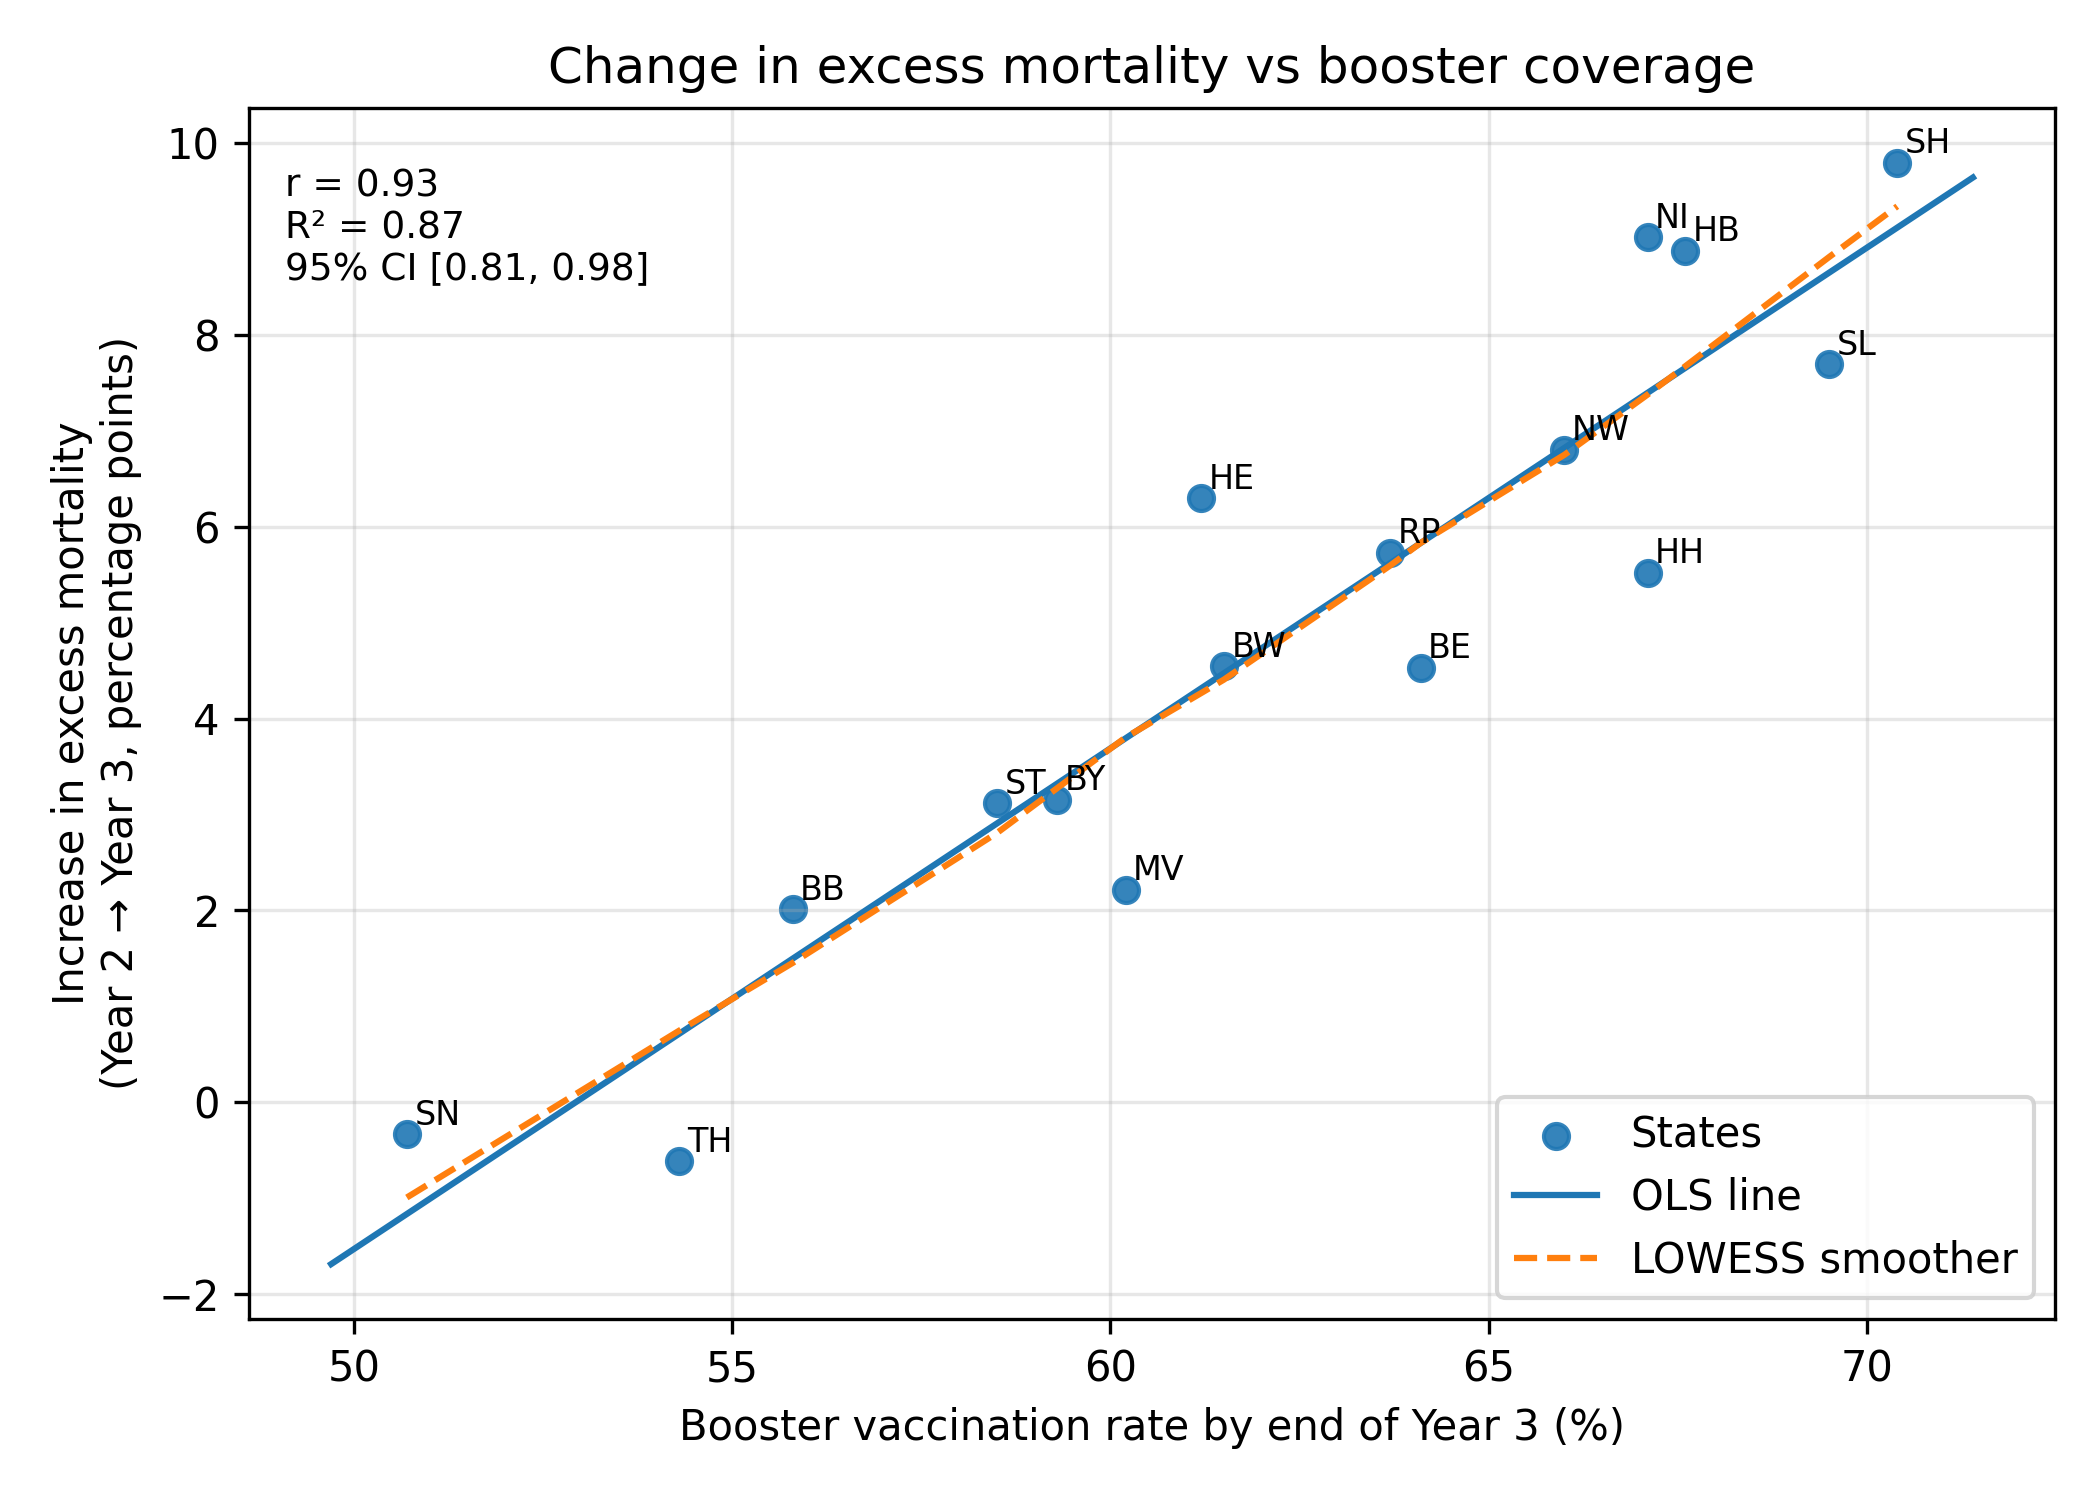

In [30]:
r, r_lo, r_hi = corr_with_ci(booster, delta23)
r2 = r**2
print(f"Booster vs ΔEM Year2→3: r={r:.3f}, R²={r2:.3f}, 95% CI=({r_lo:.3f}, {r_hi:.3f})")

plt.figure(figsize=(7, 5))

# scatter
plt.scatter(booster, delta23, label="States", alpha=0.9)

# ordinary least-squares regression line (same as before)
m, b = np.polyfit(booster, delta23, 1)
x_line = np.linspace(booster.min() - 1, booster.max() + 1, 200)
plt.plot(x_line, m * x_line + b, label="OLS line", linestyle="-", linewidth=1.5)

# LOWESS smoother (monotonicity / linearity sanity check)
# frac ~ 0.7 is reasonable for N=16 (quite smooth, avoids overfitting noise)
lowess_fit = lowess(delta23, booster, frac=0.7, it=0, return_sorted=True)
x_lowess = lowess_fit[:, 0]
y_lowess = lowess_fit[:, 1]
plt.plot(
    x_lowess,
    y_lowess,
    label="LOWESS smoother",
    linestyle="--",
    linewidth=1.5,
)

# state labels
for i, row in df.iterrows():
    plt.text(
        row["Third_Vaccination_Rate_End_Pandemic_Year_3"] + 0.1,
        delta23.iloc[i] + 0.1,
        row["abbr"],
        fontsize=8,
    )

plt.xlabel("Booster vaccination rate by end of Year 3 (%)")
plt.ylabel("Increase in excess mortality\n(Year 2 → Year 3, percentage points)")
plt.title("Change in excess mortality vs booster coverage")

plt.grid(True, alpha=0.3)
plt.text(
    0.02,
    0.95,
    f"r = {r:.2f}\nR² = {r2:.2f}\n95% CI [{r_lo:.2f}, {r_hi:.2f}]",
    transform=plt.gca().transAxes,
    fontsize=9,
    ha="left",
    va="top",
)

plt.legend(loc="lower right")
plt.tight_layout()

# use your current figure directory here:
plt.savefig(FIG_DIR / "core_corr_booster_delta23.png")
plt.close()

from IPython.display import Image
Image(filename=str(FIG_DIR / "core_corr_booster_delta23.png"))

# 5. 3‑year trend reversal: high vs low booster states  [Figure 2]

High-booster EM means: {'Excess_mortality_Pandemic_Year1': 0.36108112737500003, 'Excess_mortality_Pandemic_Year2': 1.4295461118750001, 'Excess_mortality_Pandemic_Year3': 8.67284663525}
Low-booster EM means: {'Excess_mortality_Pandemic_Year1': 4.61798419475, 'Excess_mortality_Pandemic_Year2': 4.629116626375, 'Excess_mortality_Pandemic_Year3': 7.1778494205}


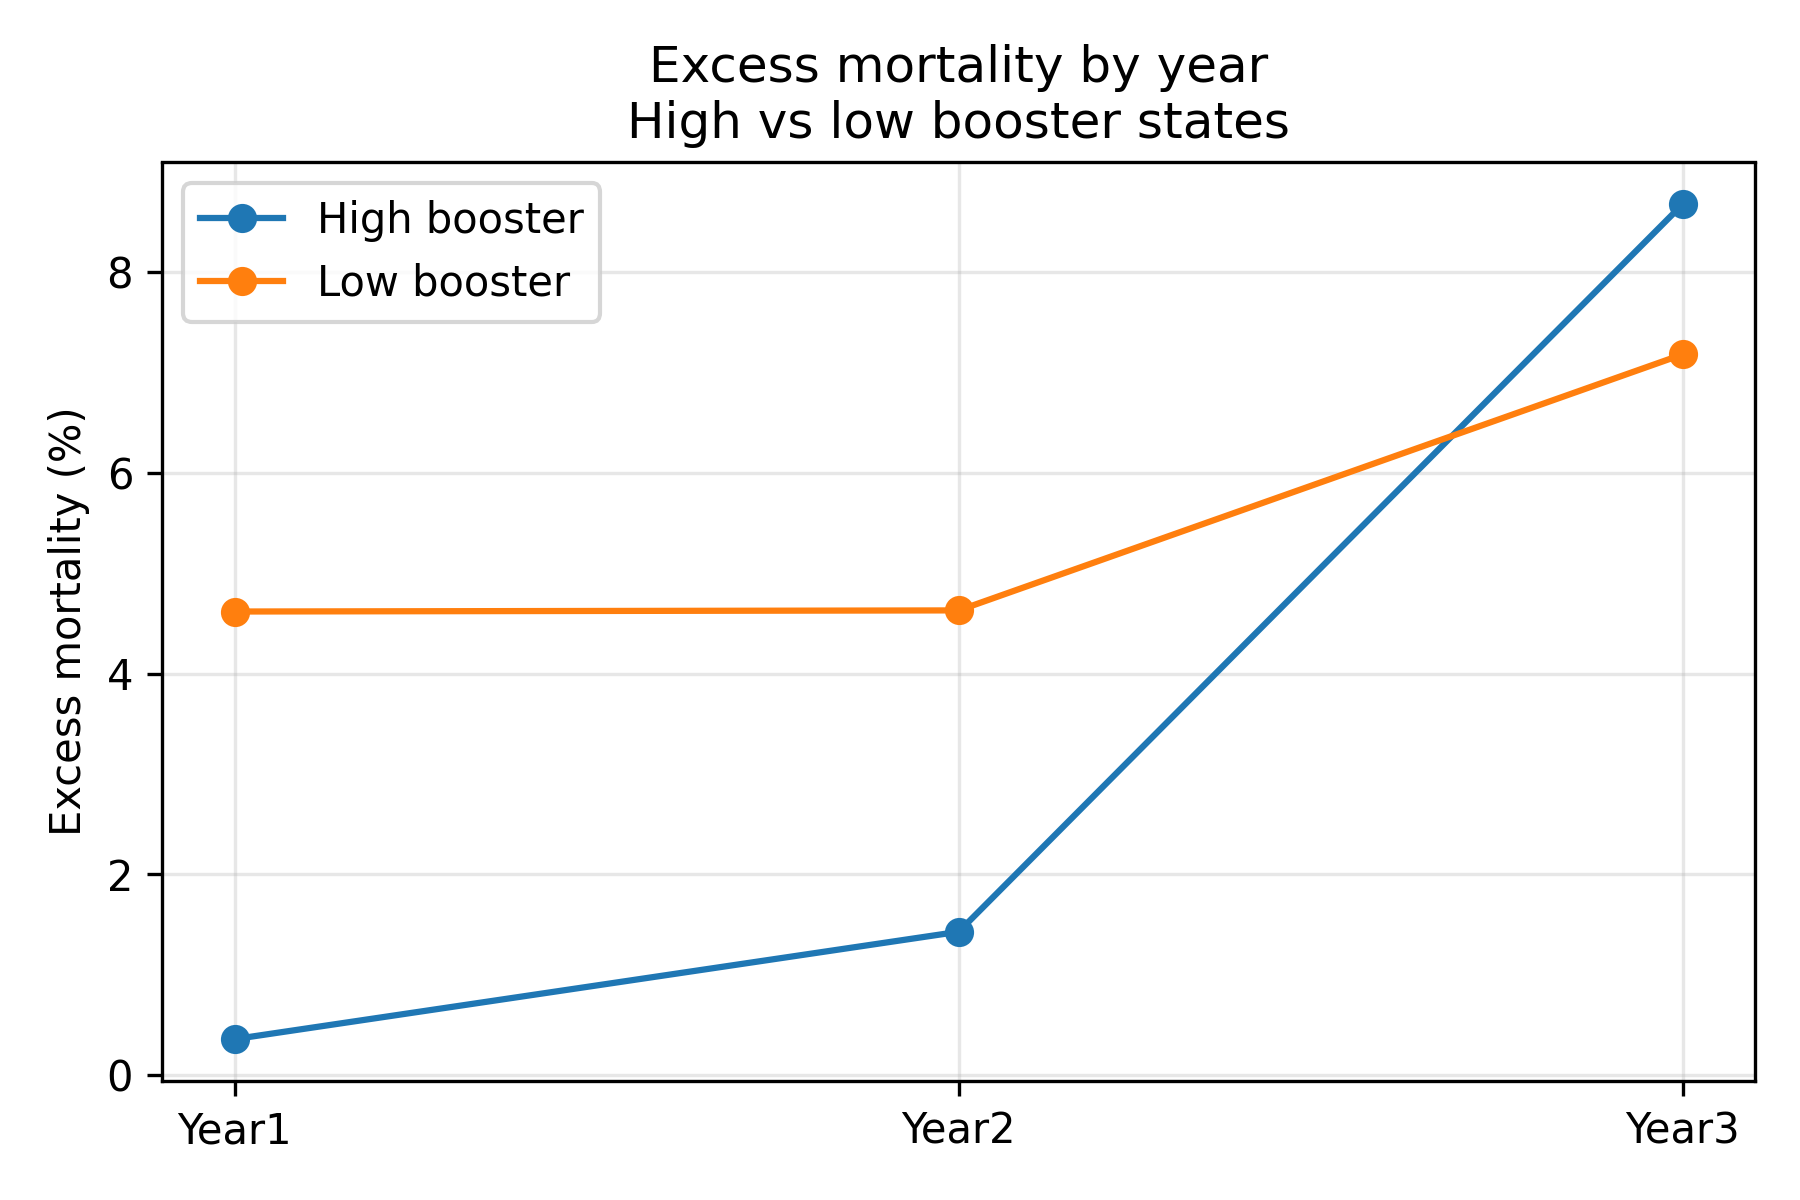

In [31]:
median_booster = booster.median()
high_mask = booster >= median_booster
low_mask = booster < median_booster

group_means = (
    df.assign(group=np.where(high_mask, "high_booster", "low_booster"))
    .groupby("group")[["Excess_mortality_Pandemic_Year1",
                       "Excess_mortality_Pandemic_Year2",
                       "Excess_mortality_Pandemic_Year3"]]
    .mean()
)
print("High-booster EM means:", group_means.loc["high_booster"].to_dict())
print("Low-booster EM means:", group_means.loc["low_booster"].to_dict())

years = np.array([1, 2, 3])
plt.figure(figsize=(6, 4))
plt.plot(years, group_means.loc["high_booster"], marker="o", label="High booster")
plt.plot(years, group_means.loc["low_booster"], marker="o", label="Low booster")
plt.xticks(years, ["Year1", "Year2", "Year3"])
plt.ylabel("Excess mortality (%)")
plt.title("Excess mortality by year\nHigh vs low booster states")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(FIG_DIR / "trend_reversal_high_low.png")
plt.close()

from IPython.display import Image
Image(filename=str(FIG_DIR / "trend_reversal_high_low.png"))

# 6. COVID deaths vs excess mortality by year  [part of Figures 3/4]

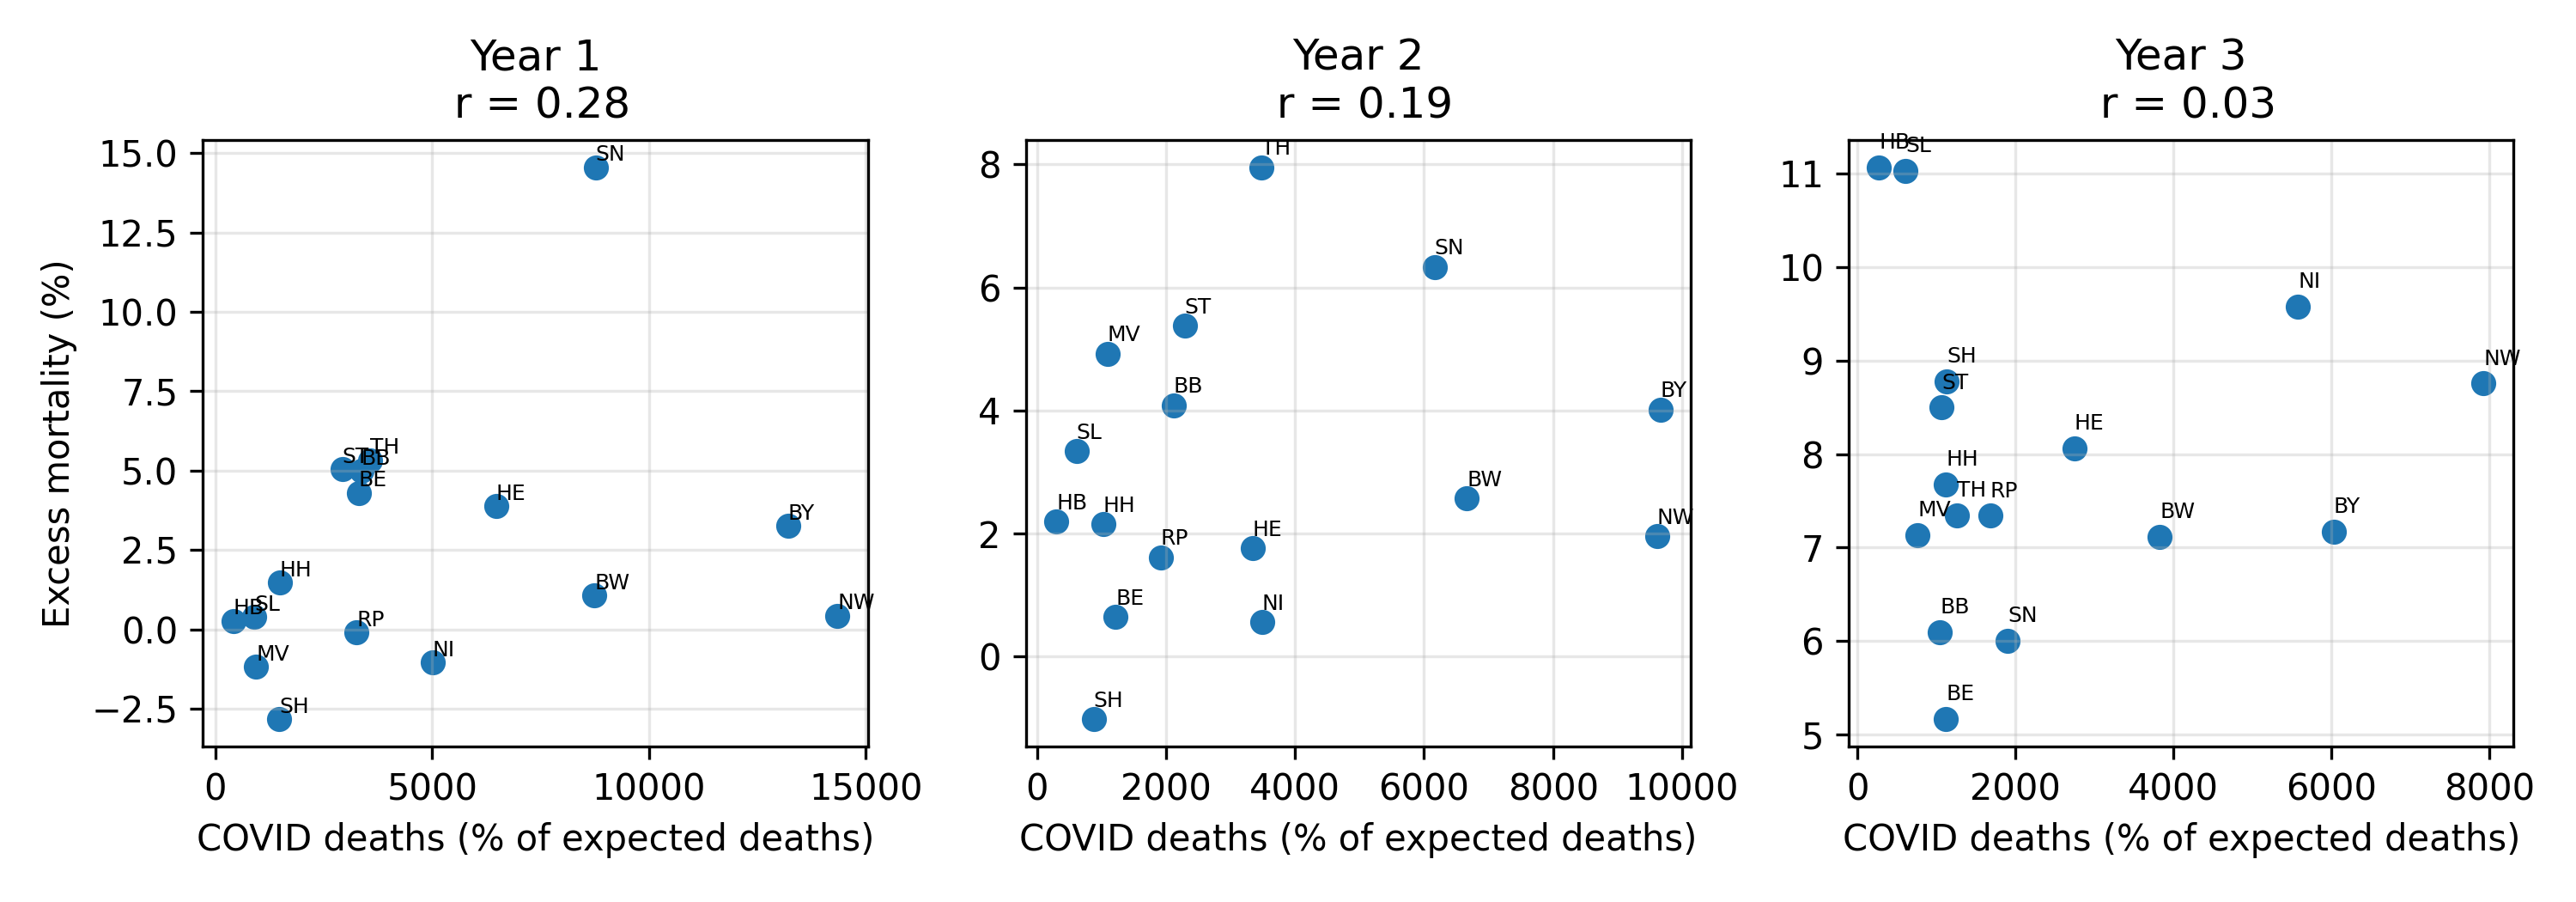

In [32]:
cov1 = df["COVID_deaths_Pandemic_Year1"]
cov2 = df["COVID_deaths_Pandemic_Year2"]
cov3 = df["COVID_deaths_Pandemic_Year3"]

plt.figure(figsize=(10, 3.5))
axes = [plt.subplot(1, 3, i + 1) for i in range(3)]
pairs = [
    (cov1, em1, "Year 1"),
    (cov2, em2, "Year 2"),
    (cov3, em3, "Year 3"),
]
for ax, (cov, em, label) in zip(axes, pairs):
    r_year = np.corrcoef(cov, em)[0, 1]
    ax.scatter(cov, em, color="tab:blue")
    for i, row in df.iterrows():
        ax.text(cov.iloc[i] + 0.02, em.iloc[i] + 0.2, row["abbr"], fontsize=6)
    ax.set_title(f"{label}\n r = {r_year:.2f}")
    ax.set_xlabel("COVID deaths (% of expected deaths)")
    if ax is axes[0]:
        ax.set_ylabel("Excess mortality (%)")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / "covid_deaths_vs_em_by_year.png")
plt.close()

from IPython.display import Image
Image(filename=str(FIG_DIR / "covid_deaths_vs_em_by_year.png"))

# 7. Booster vs COVID outcomes (Year 3)  [completes Figures 3/4]

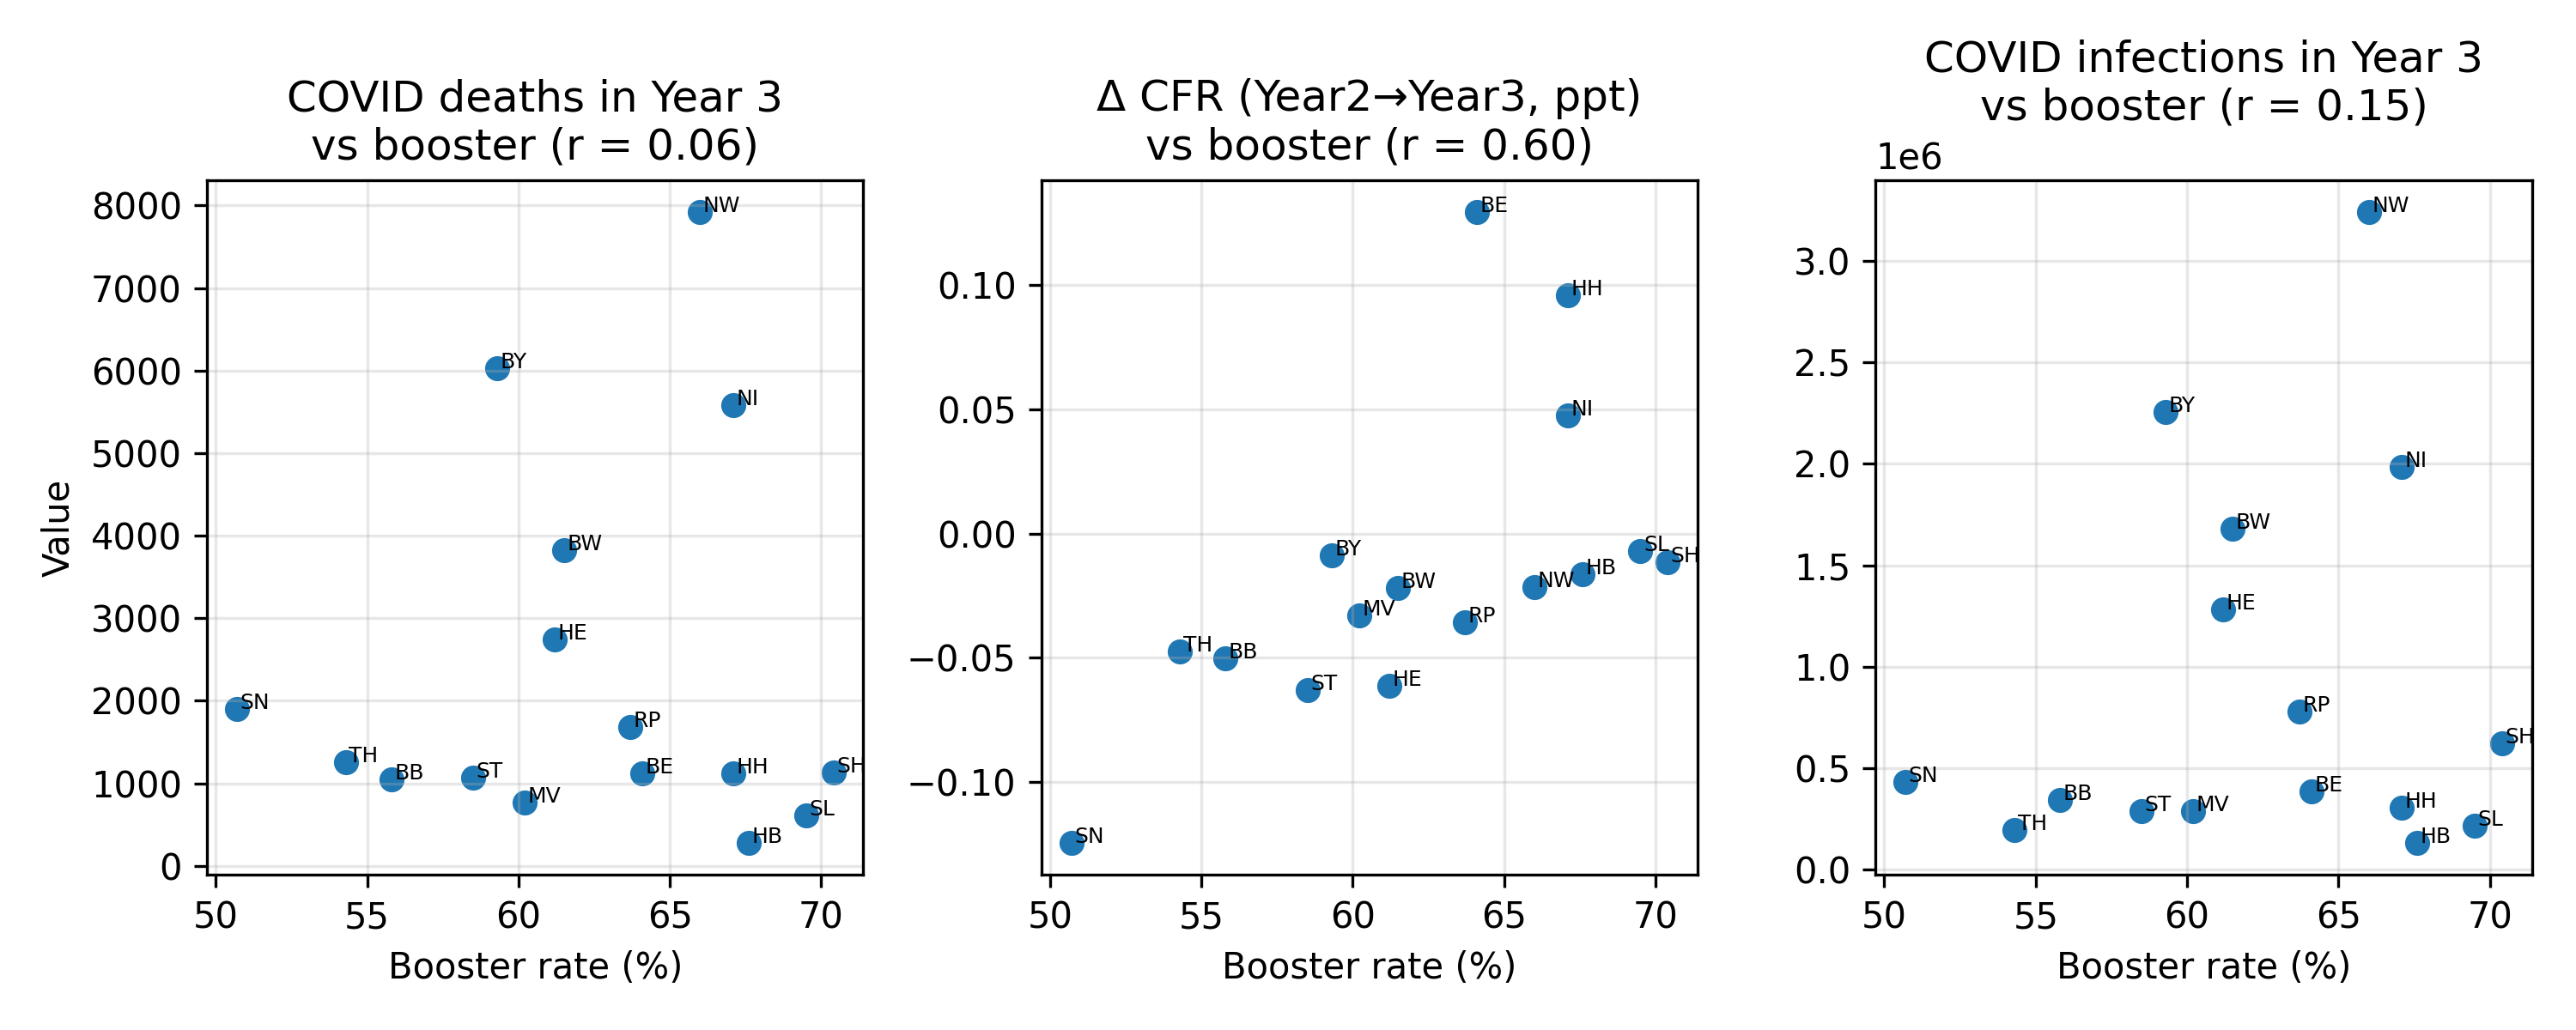

In [33]:
inf2 = df["COVID_infections_Pandemic_Year2"]
inf3 = df["COVID_infections_Pandemic_Year3"]

# crude CFR; avoid division by zero
cfr2 = cov2 / inf2.replace(0, np.nan)
cfr3 = cov3 / inf3.replace(0, np.nan)
delta_cfr = (cfr3 - cfr2) * 100.0

plt.figure(figsize=(10, 4))
axes = [plt.subplot(1, 3, i + 1) for i in range(3)]
pairs = [
    (cov3, "COVID deaths in Year 3"),
    (delta_cfr, "Δ CFR (Year2→Year3, ppt)"),
    (inf3, "COVID infections in Year 3"),
]
for ax, (y_vals, title) in zip(axes, pairs):
    r_local = np.corrcoef(booster, y_vals)[0, 1]
    ax.scatter(booster, y_vals, color="tab:blue")
    for i, row in df.iterrows():
        ax.text(
            booster.iloc[i] + 0.1,
            y_vals.iloc[i],
            row["abbr"],
            fontsize=6,
        )
    ax.set_title(f"{title}\nvs booster (r = {r_local:.2f})")
    ax.set_xlabel("Booster rate (%)")
    if ax is axes[0]:
        ax.set_ylabel("Value")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / "booster_vs_covid_metrics.png")
plt.close()

from IPython.display import Image
Image(filename=str(FIG_DIR / "booster_vs_covid_metrics.png"))

# 8. Predictor vs outcome correlation matrix (alternative explanations)
#     [Figure 7]

Correlation of predictors with ΔEM Y2→Y3:
Third_Vaccination_Rate_End_Pandemic_Year_3     0.931651
Second_Vaccination_Rate_End_Pandemic_Year_3    0.794929
Risk_of_poverty_rate_2022                      0.386318
GDP_per_capita_2022                            0.327716
COVID_infections_Pandemic_Year3                0.247523
COVID_deaths_Pandemic_Year3                    0.150584
Measures_Overall_Pandemic_Year3               -0.006370
Care_Needs_Percent_31.12.2021                 -0.393007
Mean_Age_2022                                 -0.487236
Name: Delta_EM_Year2_3, dtype: float64


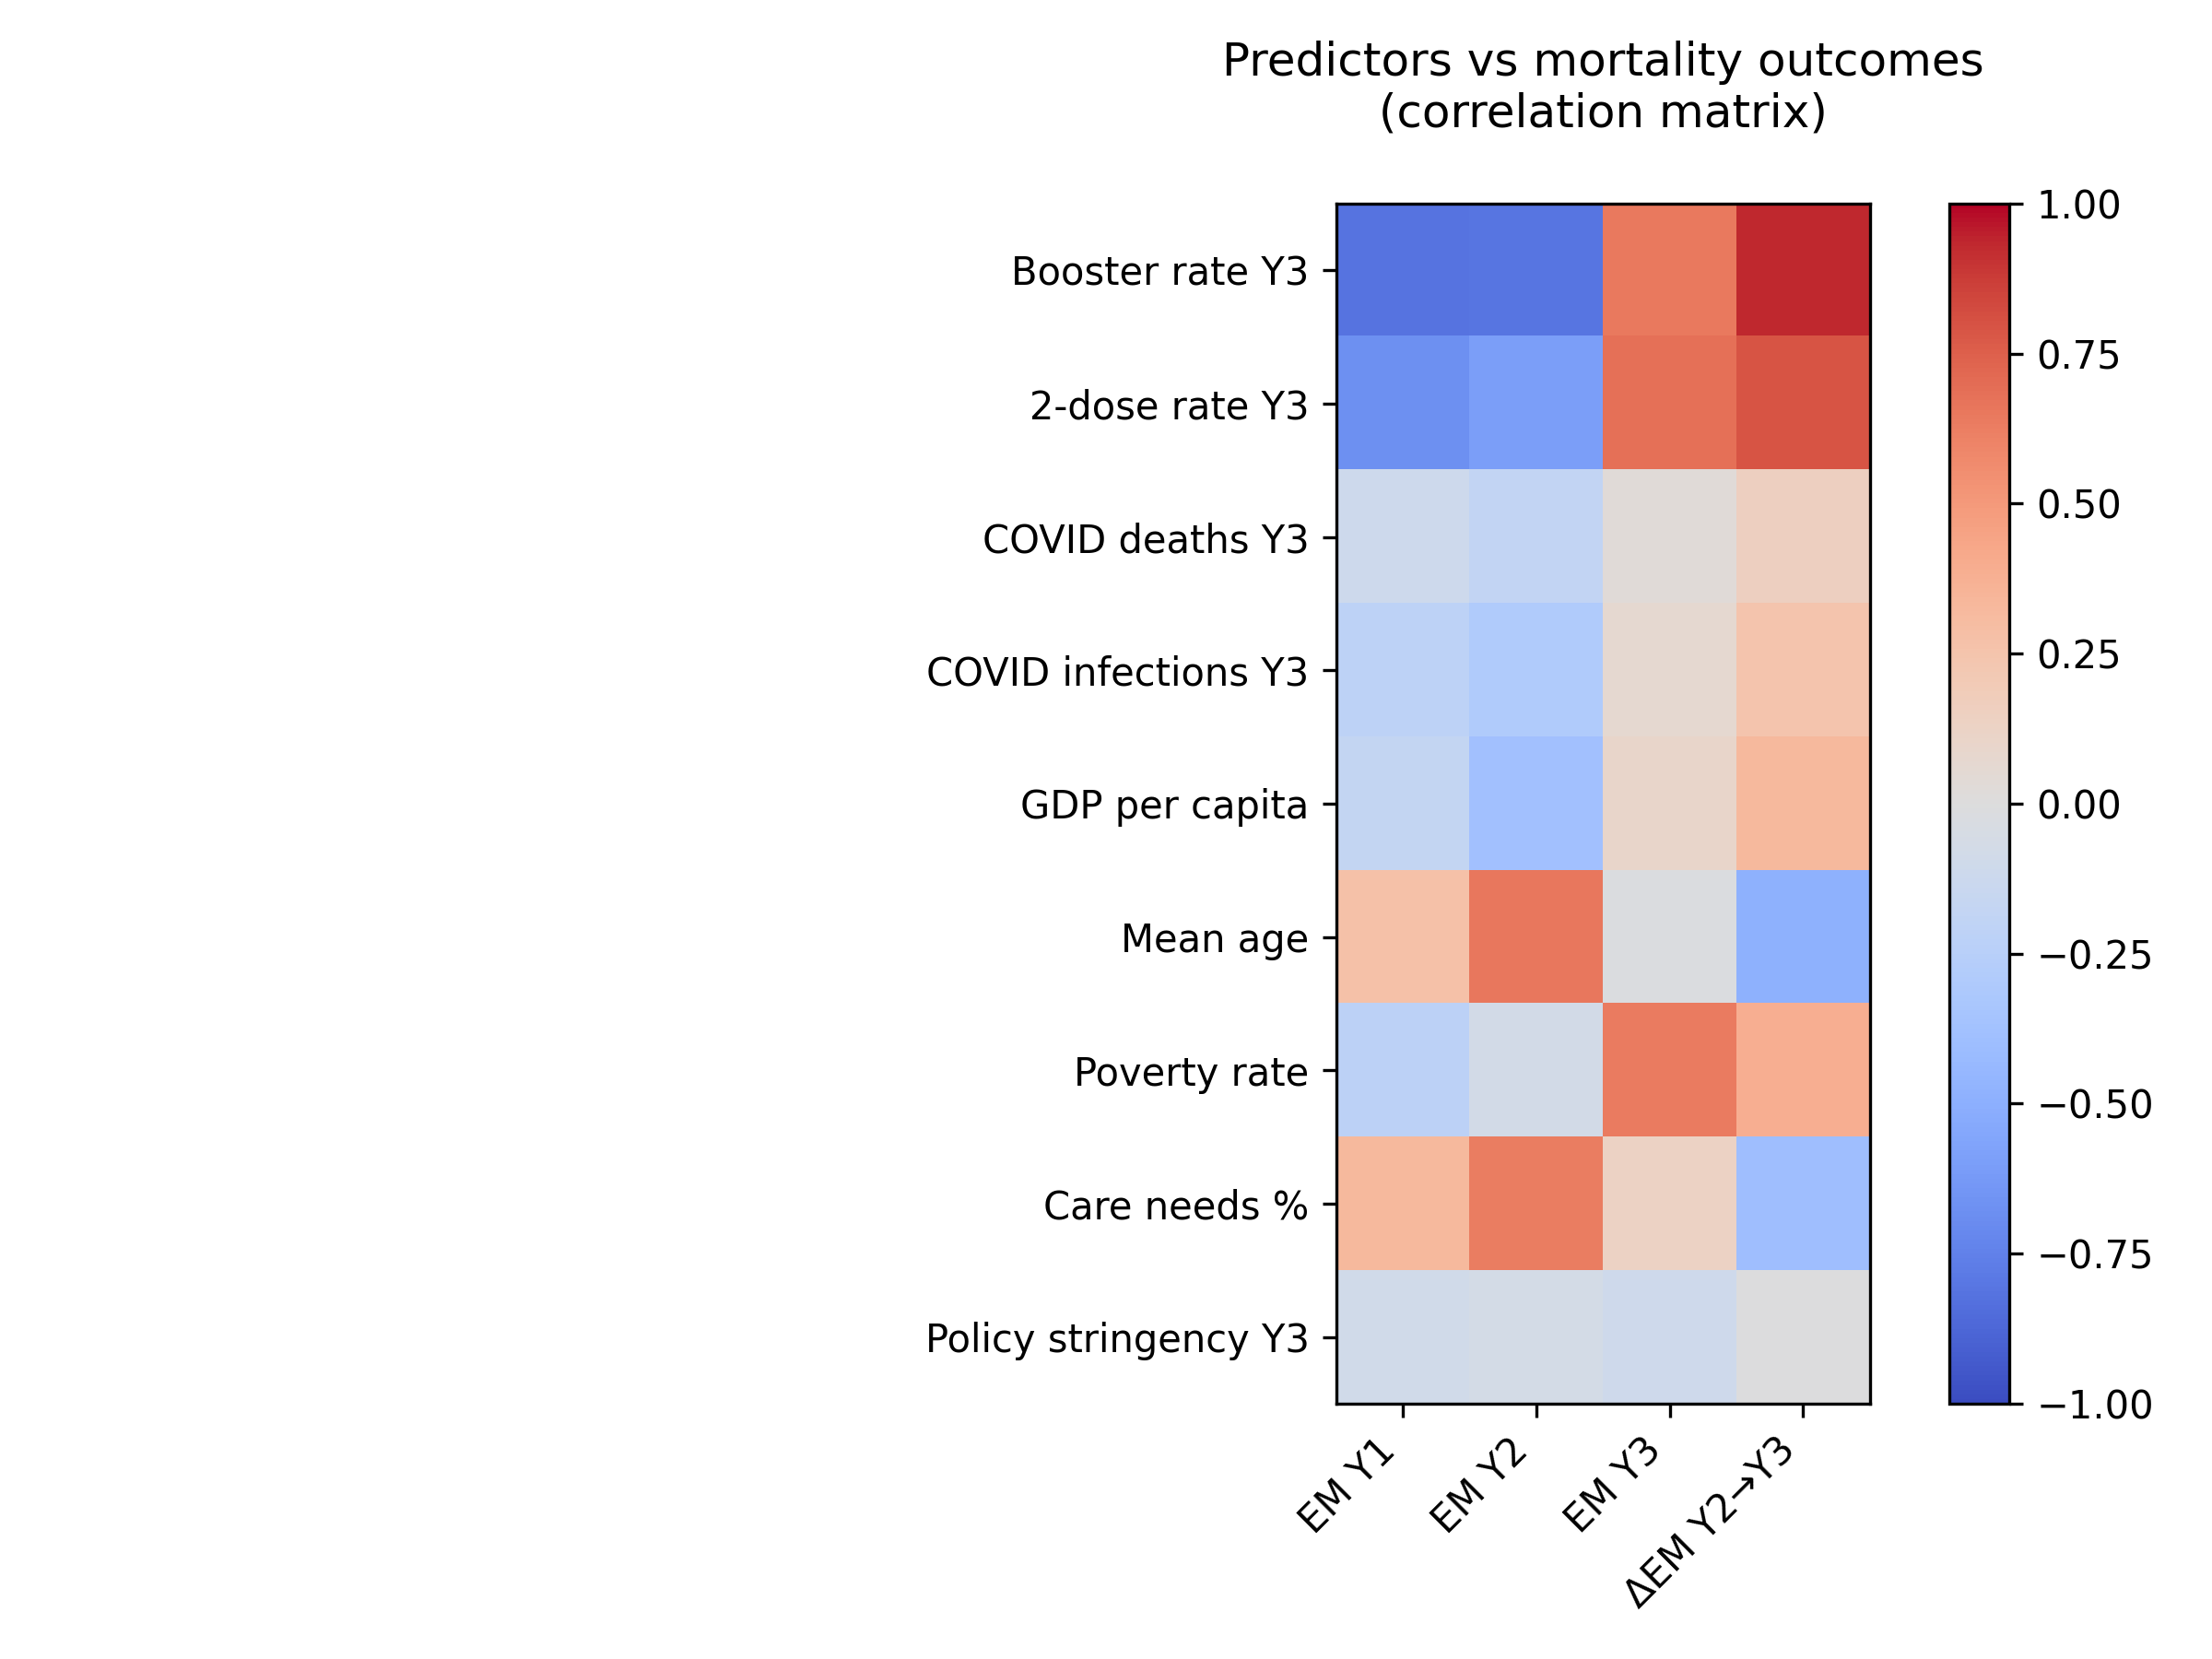

In [34]:
df["Delta_EM_Year2_3"] = delta23

outcomes = [
    "Excess_mortality_Pandemic_Year1",
    "Excess_mortality_Pandemic_Year2",
    "Excess_mortality_Pandemic_Year3",
    "Delta_EM_Year2_3",
]
predictors = [
    "Third_Vaccination_Rate_End_Pandemic_Year_3",
    "Second_Vaccination_Rate_End_Pandemic_Year_3",
    "COVID_deaths_Pandemic_Year3",
    "COVID_infections_Pandemic_Year3",
    "GDP_per_capita_2022",
    "Mean_Age_2022",
    "Risk_of_poverty_rate_2022",
    "Care_Needs_Percent_31.12.2021",
    "Measures_Overall_Pandemic_Year3",
]

for col in predictors + outcomes:
    if df[col].dtype == object:
        df[col] = df[col].astype(str).str.replace(",", ".", regex=False).astype(float)

corr_all = df[predictors + outcomes].corr()
corr_sub = corr_all.loc[predictors, outcomes]

plt.figure(figsize=(8, 6))
im = plt.imshow(corr_sub, vmin=-1, vmax=1, cmap="coolwarm")
plt.xticks(
    range(len(outcomes)),
    ["EM Y1", "EM Y2", "EM Y3", "ΔEM Y2→Y3"],
    rotation=45,
    ha="right",
)
plt.yticks(
    range(len(predictors)),
    [
        "Booster rate Y3",
        "2-dose rate Y3",
        "COVID deaths Y3",
        "COVID infections Y3",
        "GDP per capita",
        "Mean age",
        "Poverty rate",
        "Care needs %",
        "Policy stringency Y3",
    ],
)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Predictors vs mortality outcomes\n(correlation matrix)", pad=20)
plt.tight_layout()
plt.savefig(FIG_DIR / "predictor_outcome_heatmap.png")
plt.close()

print("Correlation of predictors with ΔEM Y2→Y3:")
print(corr_sub["Delta_EM_Year2_3"].sort_values(ascending=False))

from IPython.display import Image
Image(filename=str(FIG_DIR / "predictor_outcome_heatmap.png"))

# 9a. Jackknife & permutation robustness  [Figures 5 & 6]

Jackknife r range: 0.919254 – 0.945693
Permutation p-value (two-sided, |r_perm| >= |r_obs|): 0.00020


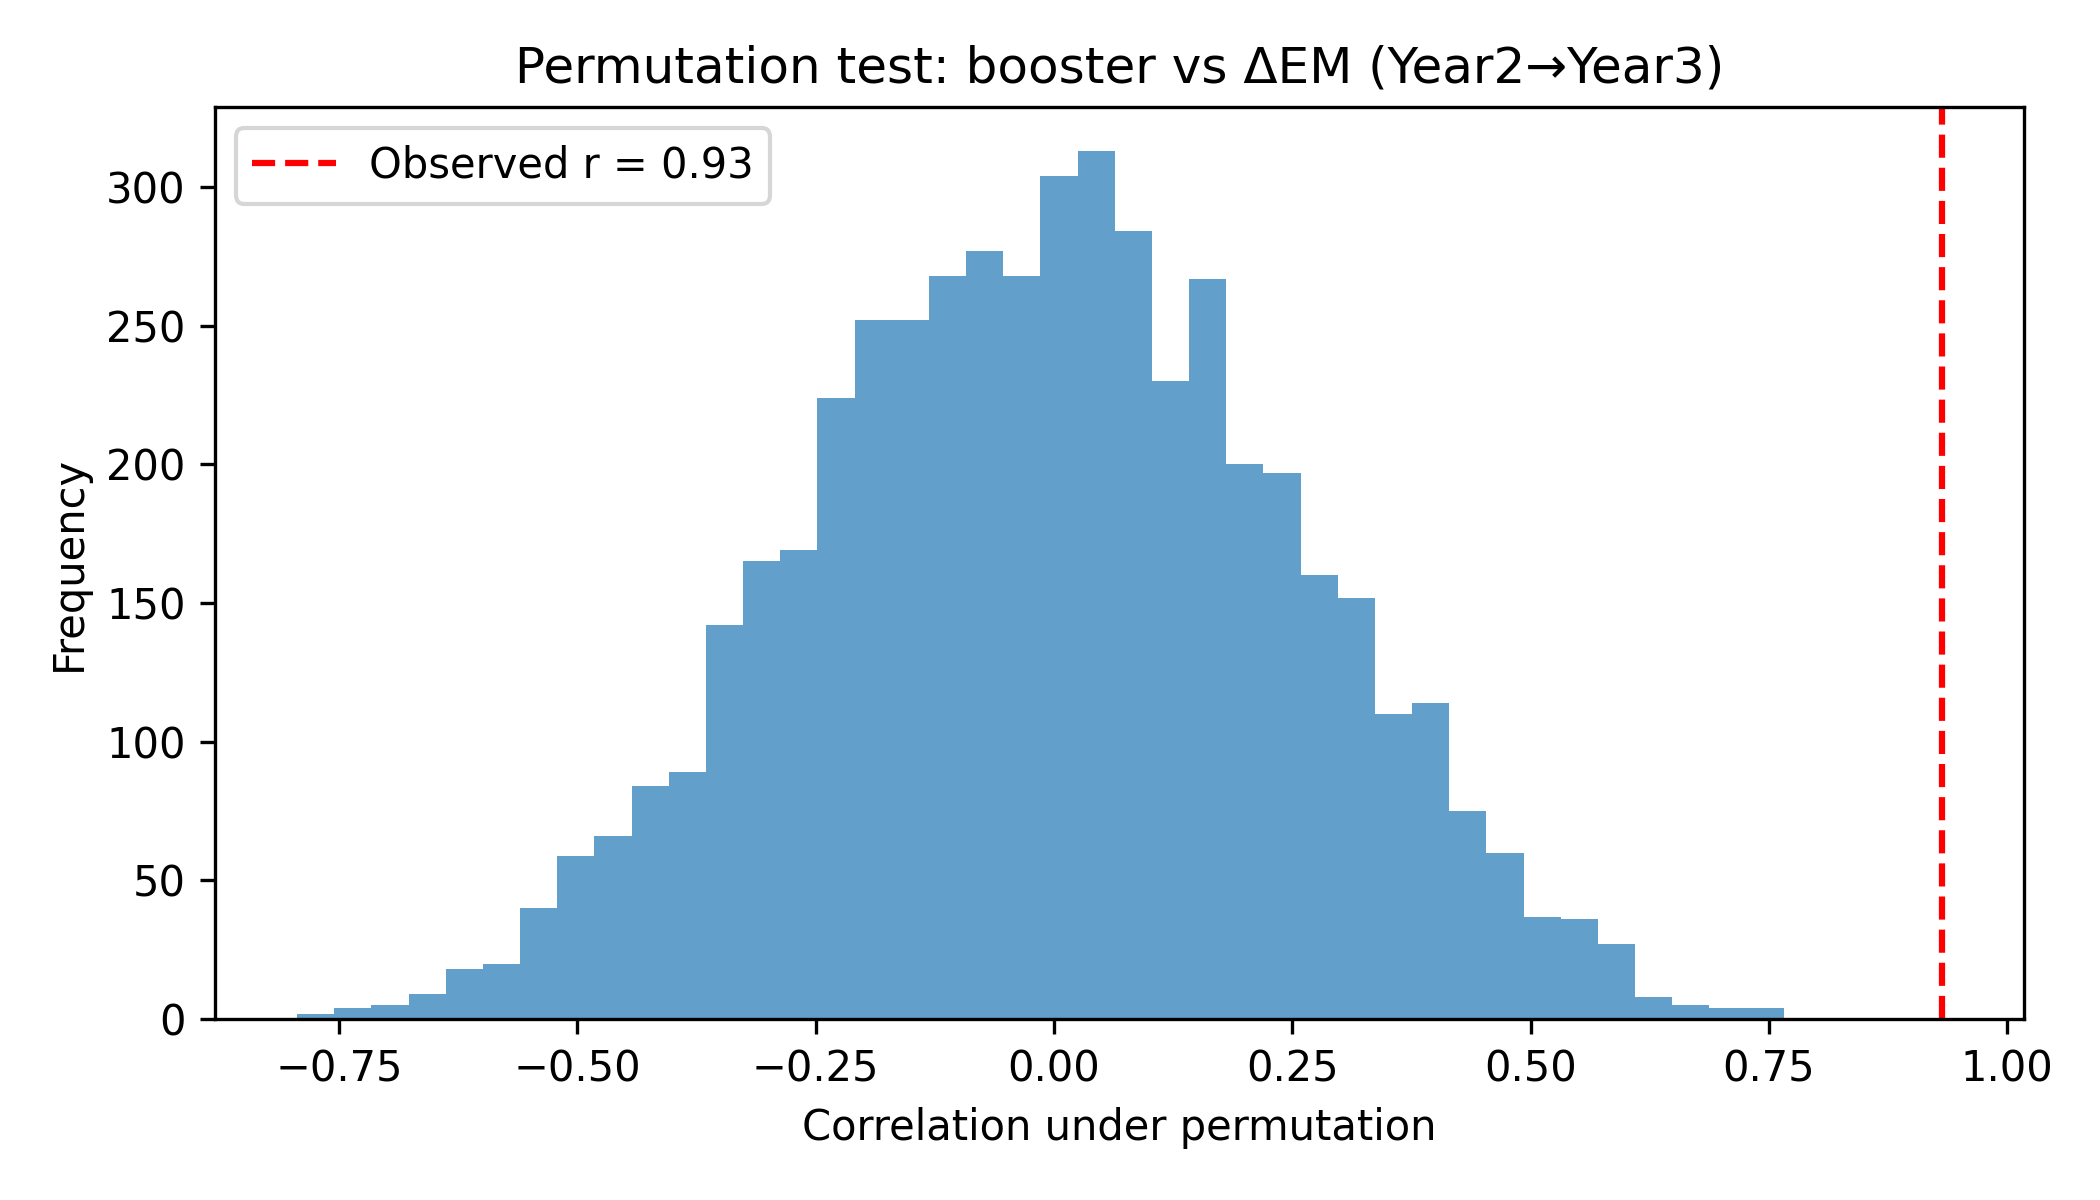

In [35]:
jackknife_rs = []
labels = []

for i in range(len(df)):
    mask = df.index != i
    r_i = np.corrcoef(booster[mask], delta23[mask])[0, 1]
    jackknife_rs.append(r_i)
    labels.append(df["abbr"].iloc[i])

plt.figure(figsize=(7, 4))
plt.bar(range(len(jackknife_rs)), jackknife_rs)
plt.axhline(r, color="red", linestyle="--", label=f"Full-sample r = {r:.2f}")
plt.xticks(range(len(jackknife_rs)), labels, rotation=45, ha="right")
plt.ylabel("Leave-one-out correlation r")
plt.title("Jackknife correlations: booster vs ΔEM (Year2→Year3)")
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / "jackknife_correlations.png")
plt.close()

print(
    "Jackknife r range:",
    f"{min(jackknife_rs):.6f} – {max(jackknife_rs):.6f}"
)

# Permutation test (with fixed RNG seed for reproducibility)
n_perm = 5000
rng = np.random.default_rng(42)       # <--- seeded RNG
perm_rs = np.empty(n_perm)

for i in range(n_perm):
    perm_booster = rng.permutation(booster.to_numpy())
    perm_rs[i] = np.corrcoef(perm_booster, delta23)[0, 1]

p_perm = (np.sum(np.abs(perm_rs) >= abs(r)) + 1) / (n_perm + 1)
print(f"Permutation p-value (two-sided, |r_perm| >= |r_obs|): {p_perm:.5f}")

plt.figure(figsize=(7, 4))
plt.hist(perm_rs, bins=40, alpha=0.7)
plt.axvline(r, color="red", linestyle="--", label=f"Observed r = {r:.2f}")
plt.xlabel("Correlation under permutation")
plt.ylabel("Frequency")
plt.title("Permutation test: booster vs ΔEM (Year2→Year3)")
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / "permutation_histogram.png")
plt.close()

from IPython.display import Image
Image(filename=str(FIG_DIR / "permutation_histogram.png"))

# 9b. Spearman + bootstrap CI

Spearman rho (booster vs ΔEM Y2→Y3) = 0.915, p = 6.65e-07
Bootstrap 95% CI for Pearson r: [0.844, 0.973]


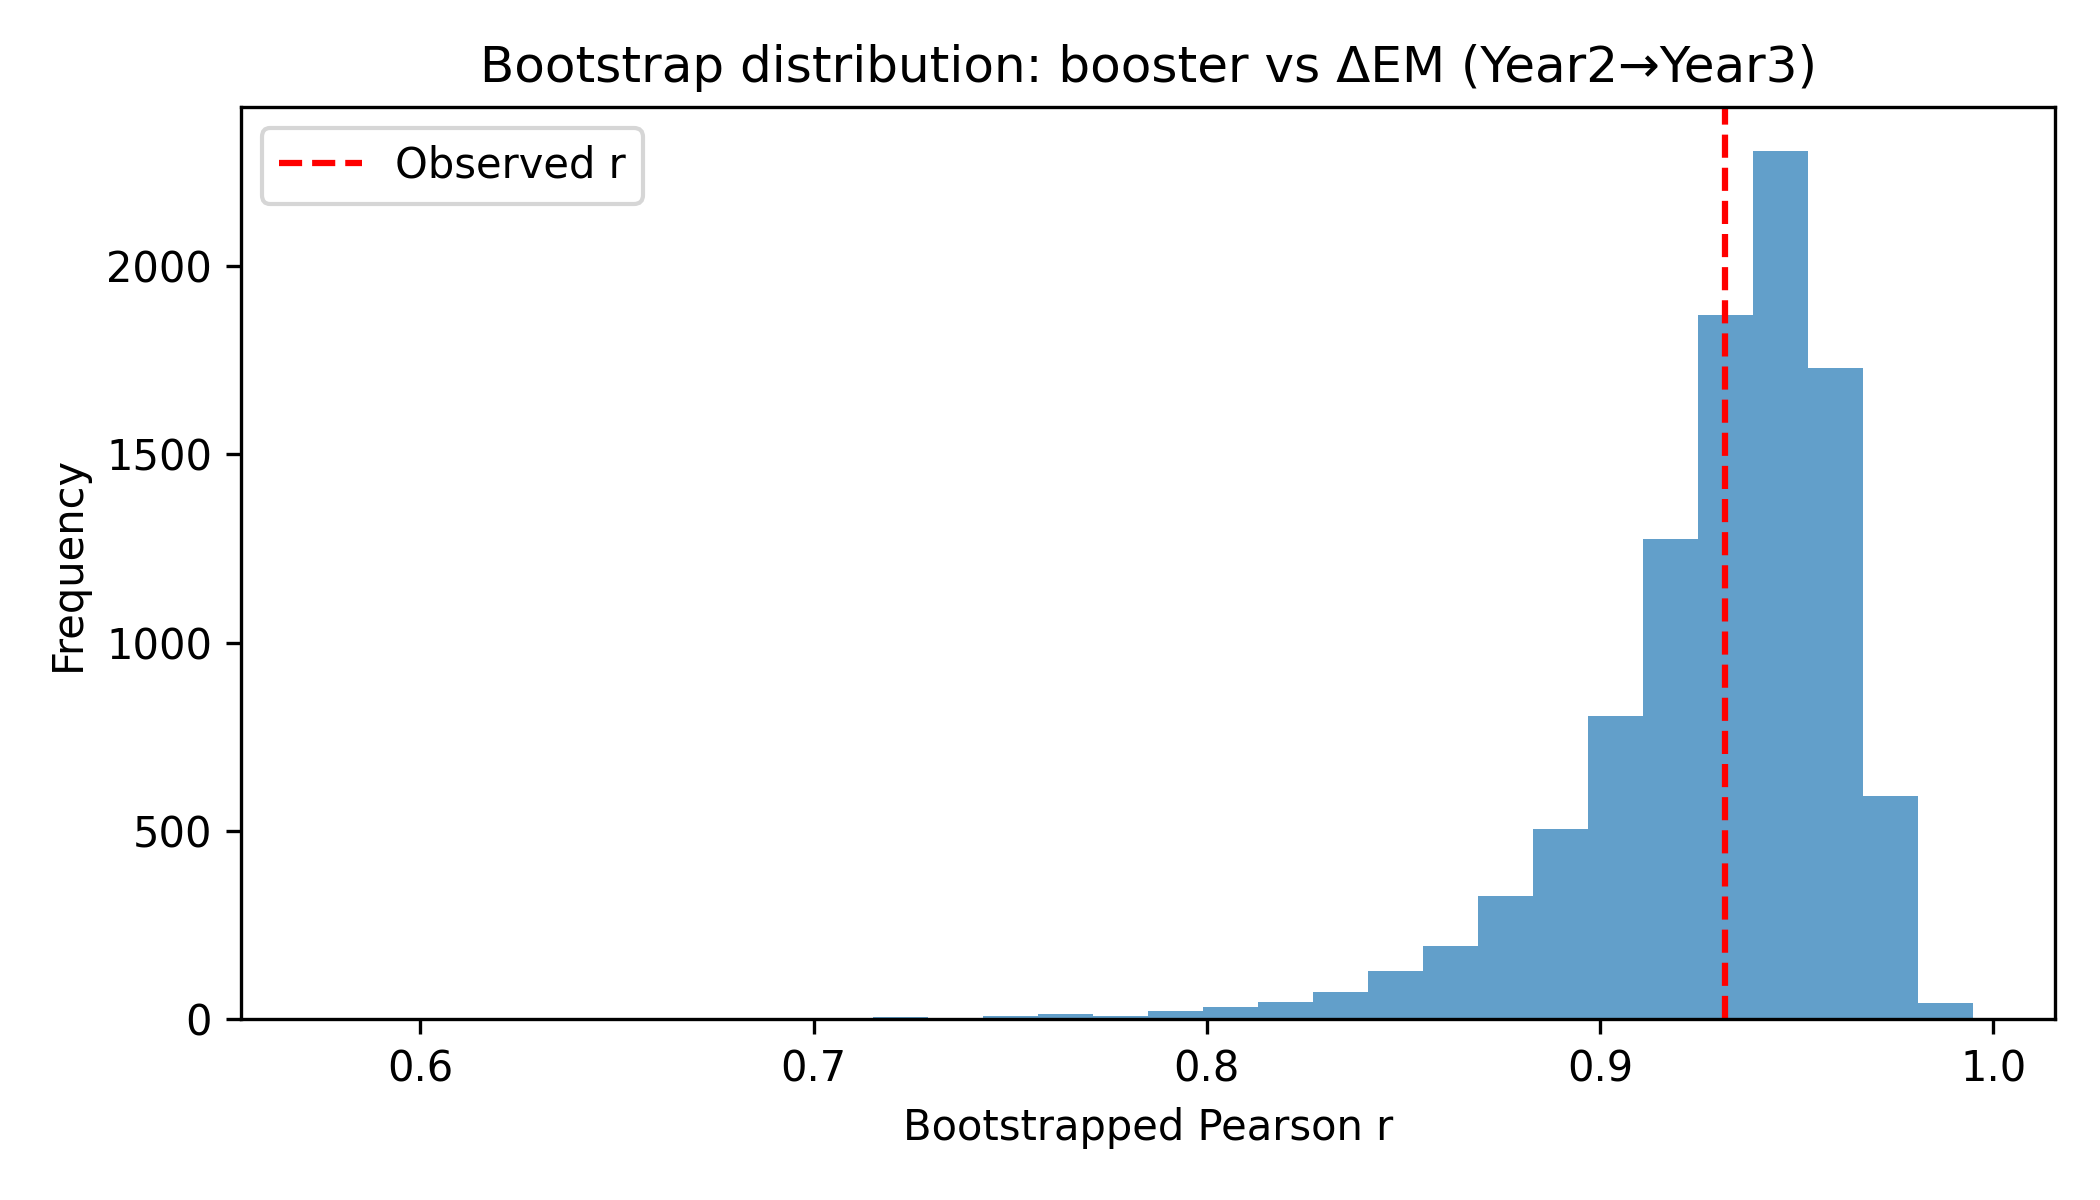

In [36]:
x = booster.to_numpy()
y = delta23.to_numpy()
n = len(df)

rho_spear, p_spear = stats.spearmanr(x, y)
print(f"Spearman rho (booster vs ΔEM Y2→Y3) = {rho_spear:.3f}, p = {p_spear:.3g}")

rng = np.random.default_rng(42)
n_boot = 10000
boot_rs = np.empty(n_boot)
for i in range(n_boot):
    idx = rng.integers(0, n, size=n)
    r_i, _ = stats.pearsonr(x[idx], y[idx])
    boot_rs[i] = r_i

ci_low_boot, ci_high_boot = np.percentile(boot_rs, [2.5, 97.5])
print(f"Bootstrap 95% CI for Pearson r: [{ci_low_boot:.3f}, {ci_high_boot:.3f}]")

plt.figure(figsize=(7, 4))
plt.hist(boot_rs, bins=30, alpha=0.7)
plt.axvline(r, color="red", linestyle="--", label="Observed r")
plt.xlabel("Bootstrapped Pearson r")
plt.ylabel("Frequency")
plt.title("Bootstrap distribution: booster vs ΔEM (Year2→Year3)")
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / "bootstrap_r_booster_delta23.png")
plt.close()

from IPython.display import Image
Image(filename=str(FIG_DIR / "bootstrap_r_booster_delta23.png"))

# 9c. Partial correlations: booster vs ΔEM | EM Year1 / Years1&2

In [37]:
def partial_corr(x, y, controls):
    """
    Residual-based partial correlation between x and y, controlling for 'controls'.
    x, y: 1D arrays (length n)
    controls: 1D or 2D array
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    Z = np.asarray(controls, dtype=float)
    if Z.ndim == 1:
        Z = Z[:, None]
    n_loc = len(x)
    Z_design = np.column_stack([np.ones(n_loc), Z])
    beta_x, *_ = np.linalg.lstsq(Z_design, x, rcond=None)
    res_x = x - Z_design @ beta_x
    beta_y, *_ = np.linalg.lstsq(Z_design, y, rcond=None)
    res_y = y - Z_design @ beta_y
    r_pcorr, p_pcorr = stats.pearsonr(res_x, res_y)
    return r_pcorr, p_pcorr

r_p_y1, p_p_y1 = partial_corr(booster, delta23, em1)
print(f"Partial r (booster vs ΔEM | EM Year1): r = {r_p_y1:.3f}, p ≈ {p_p_y1:.3g}")

controls_y1y2 = np.column_stack([em1.to_numpy(), em2.to_numpy()])
r_p_y1y2, p_p_y1y2 = partial_corr(booster, delta23, controls_y1y2)
print(f"Partial r (booster vs ΔEM | EM Years1&2): r = {r_p_y1y2:.3f}, p ≈ {p_p_y1y2:.3g}")

Partial r (booster vs ΔEM | EM Year1): r = 0.849, p ≈ 3.2e-05
Partial r (booster vs ΔEM | EM Years1&2): r = 0.708, p ≈ 0.00214


# 9d. Multivariate OLS: ΔEM ~ booster + EM_Y2 + covariates

Covariates used in OLS: ['Third_Vaccination_Rate_End_Pandemic_Year_3', 'Excess_mortality_Pandemic_Year2', 'Mean_Age_2022', 'GDP_per_capita_2022', 'Risk_of_poverty_rate_2022']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     26.58
Date:                Sat, 06 Dec 2025   Prob (F-statistic):           1.80e-05
Time:                        16:09:42   Log-Likelihood:                -19.380
No. Observations:                  16   AIC:                             50.76
Df Residuals:                      10   BIC:                             55.40
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   

/home/codespace/.local/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=16 observations were given.
  return hypotest_fun_in(*args, **kwds)


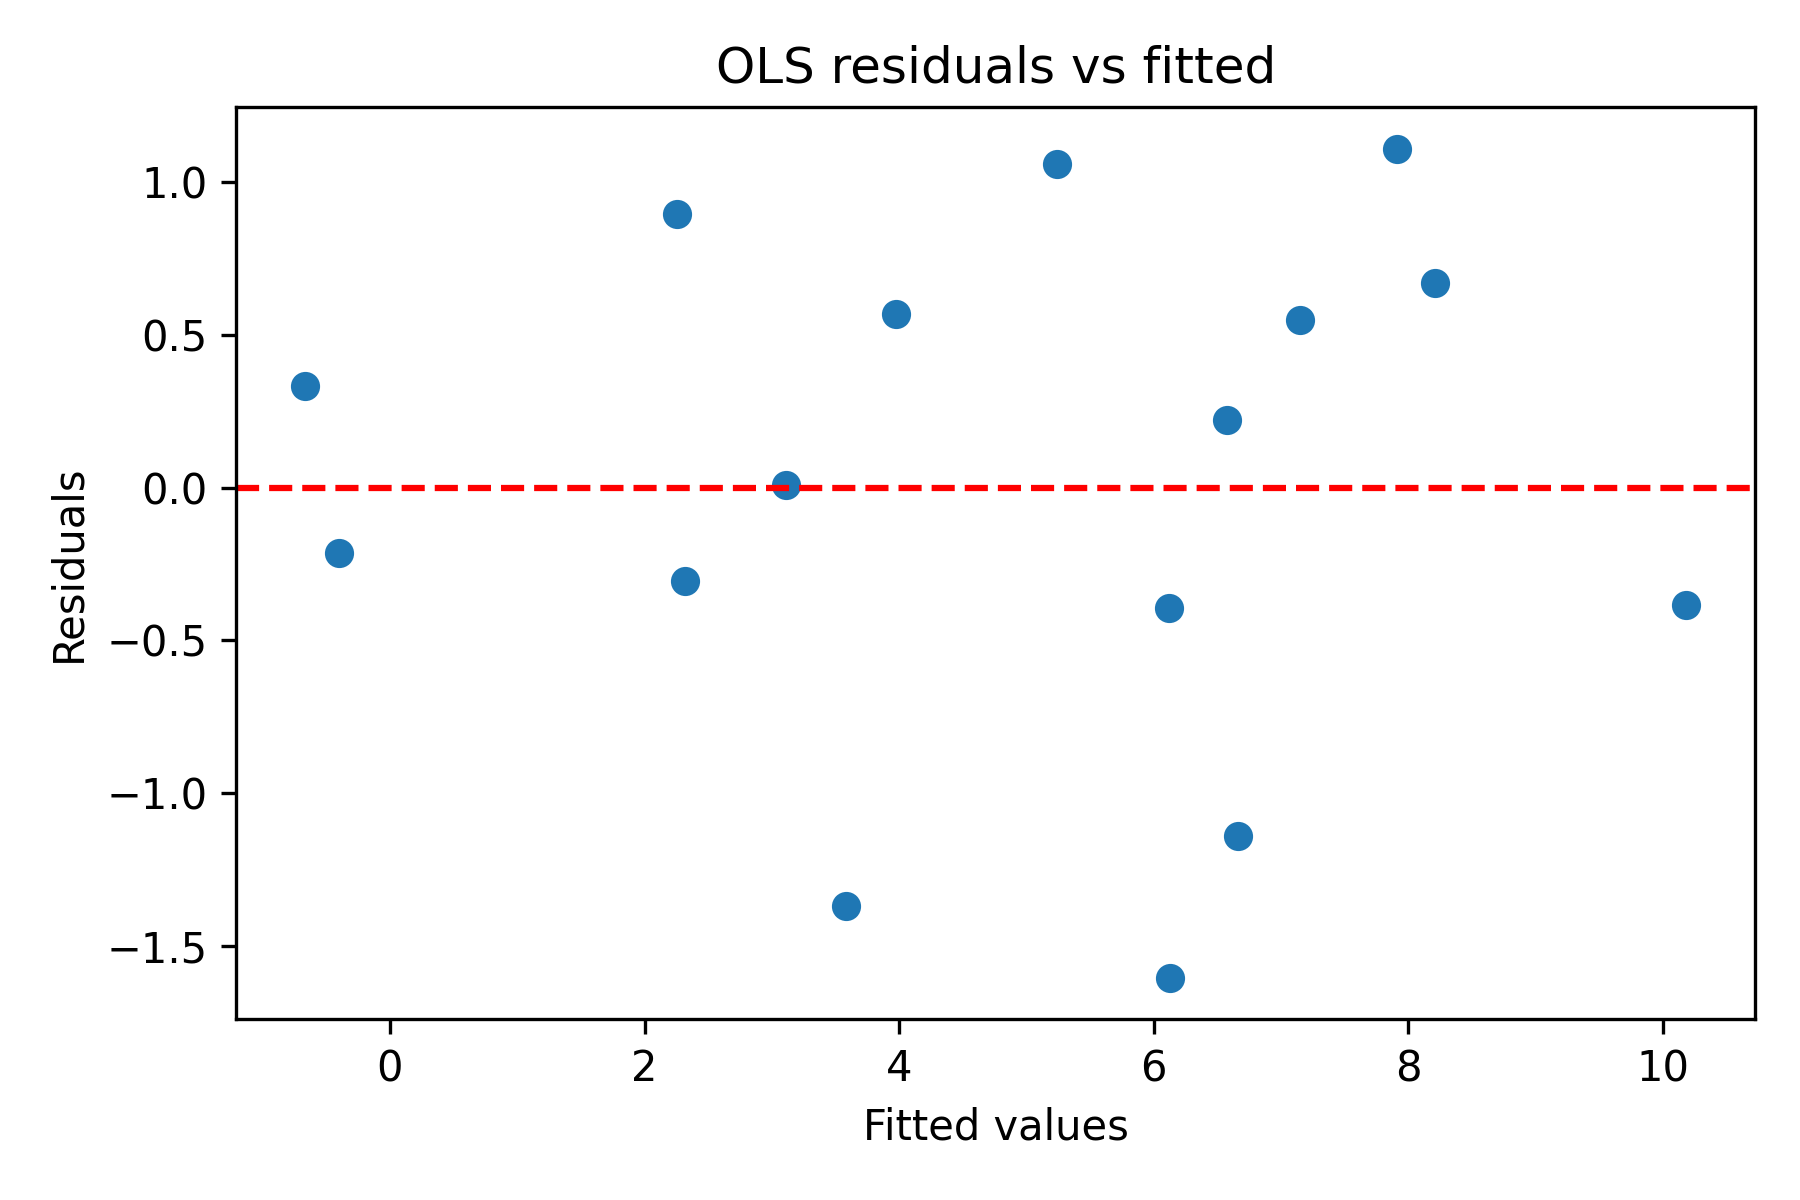

In [38]:
covariates = [
    "Third_Vaccination_Rate_End_Pandemic_Year_3",
    "Excess_mortality_Pandemic_Year2",
]
optional_covs = [
    "Mean_Age_2022",
    "GDP_per_capita_2022",
    "Risk_of_poverty_rate_2022",
]
for col in optional_covs:
    if col in df.columns:
        covariates.append(col)

print("Covariates used in OLS:", covariates)

X = df[covariates].copy()
X = sm.add_constant(X)
y_ols = delta23
ols_model = sm.OLS(y_ols, X).fit()
print(ols_model.summary())

# Residual diagnostics
resid = ols_model.resid
fitted = ols_model.fittedvalues

plt.figure(figsize=(6, 4))
plt.scatter(fitted, resid)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("OLS residuals vs fitted")
plt.tight_layout()
plt.savefig(FIG_DIR / "ols_resid_vs_fitted.png")
plt.close()

sm.qqplot(resid, line="45")
plt.title("OLS residuals QQ-plot")
plt.tight_layout()
plt.savefig(FIG_DIR / "ols_qq.png")
plt.close()

influence = ols_model.get_influence()
leverage = influence.hat_matrix_diag
cooks = influence.cooks_distance[0]
plt.figure(figsize=(6, 4))
plt.scatter(leverage, cooks)
plt.xlabel("Leverage")
plt.ylabel("Cook's distance")
plt.title("Influence diagnostics (OLS)")
plt.tight_layout()
plt.savefig(FIG_DIR / "ols_leverage_vs_cooks.png")
plt.close()

from IPython.display import Image
Image(filename=str(FIG_DIR / "ols_resid_vs_fitted.png"))

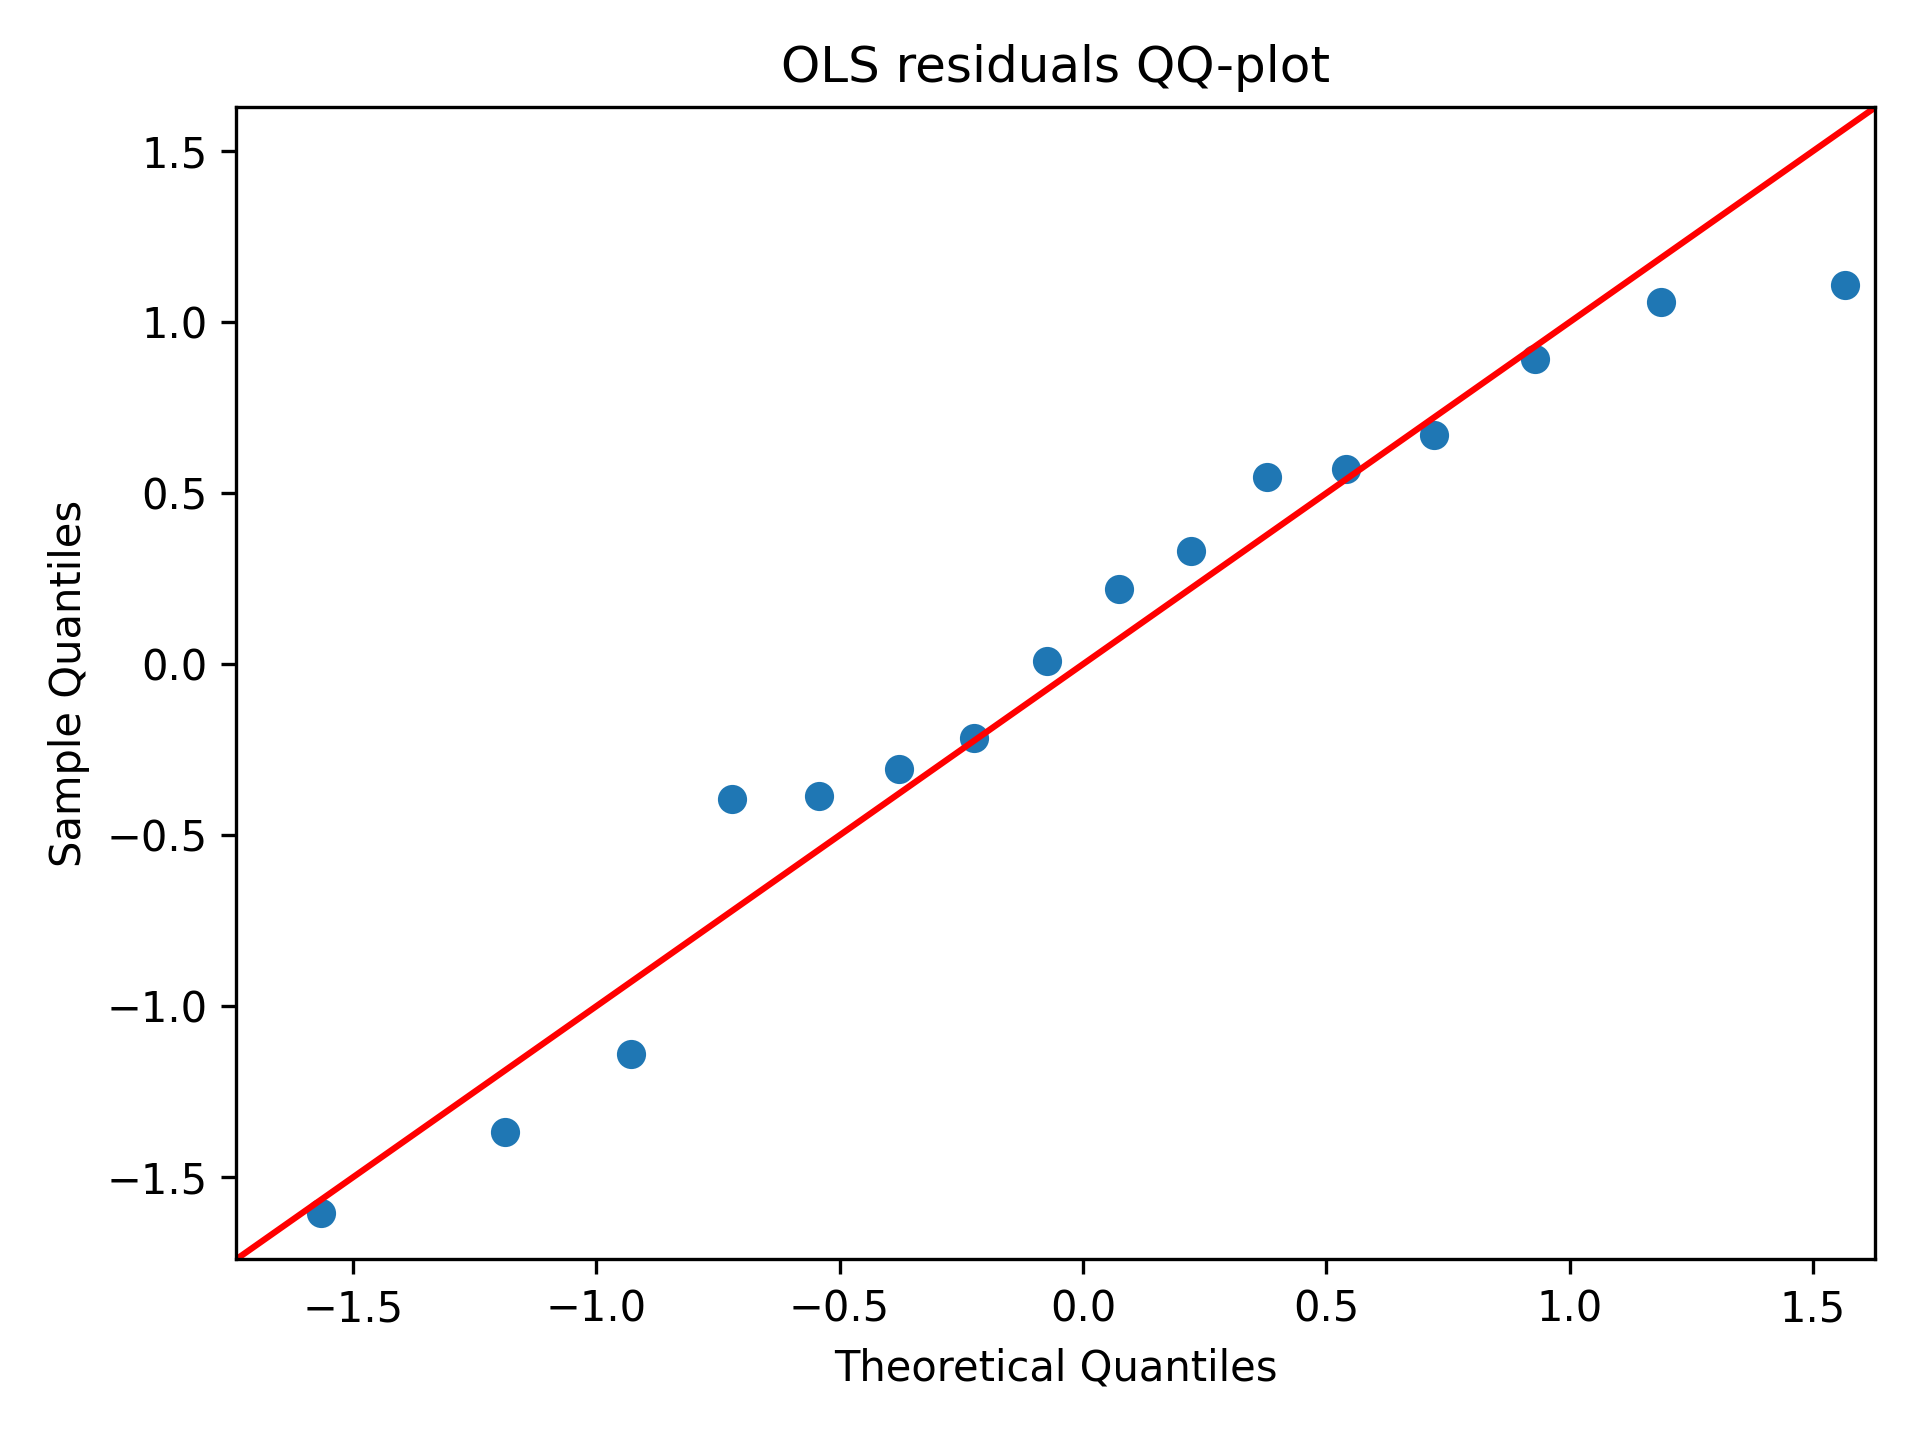

In [39]:
from IPython.display import Image
Image(filename=str(FIG_DIR / "ols_qq.png"))

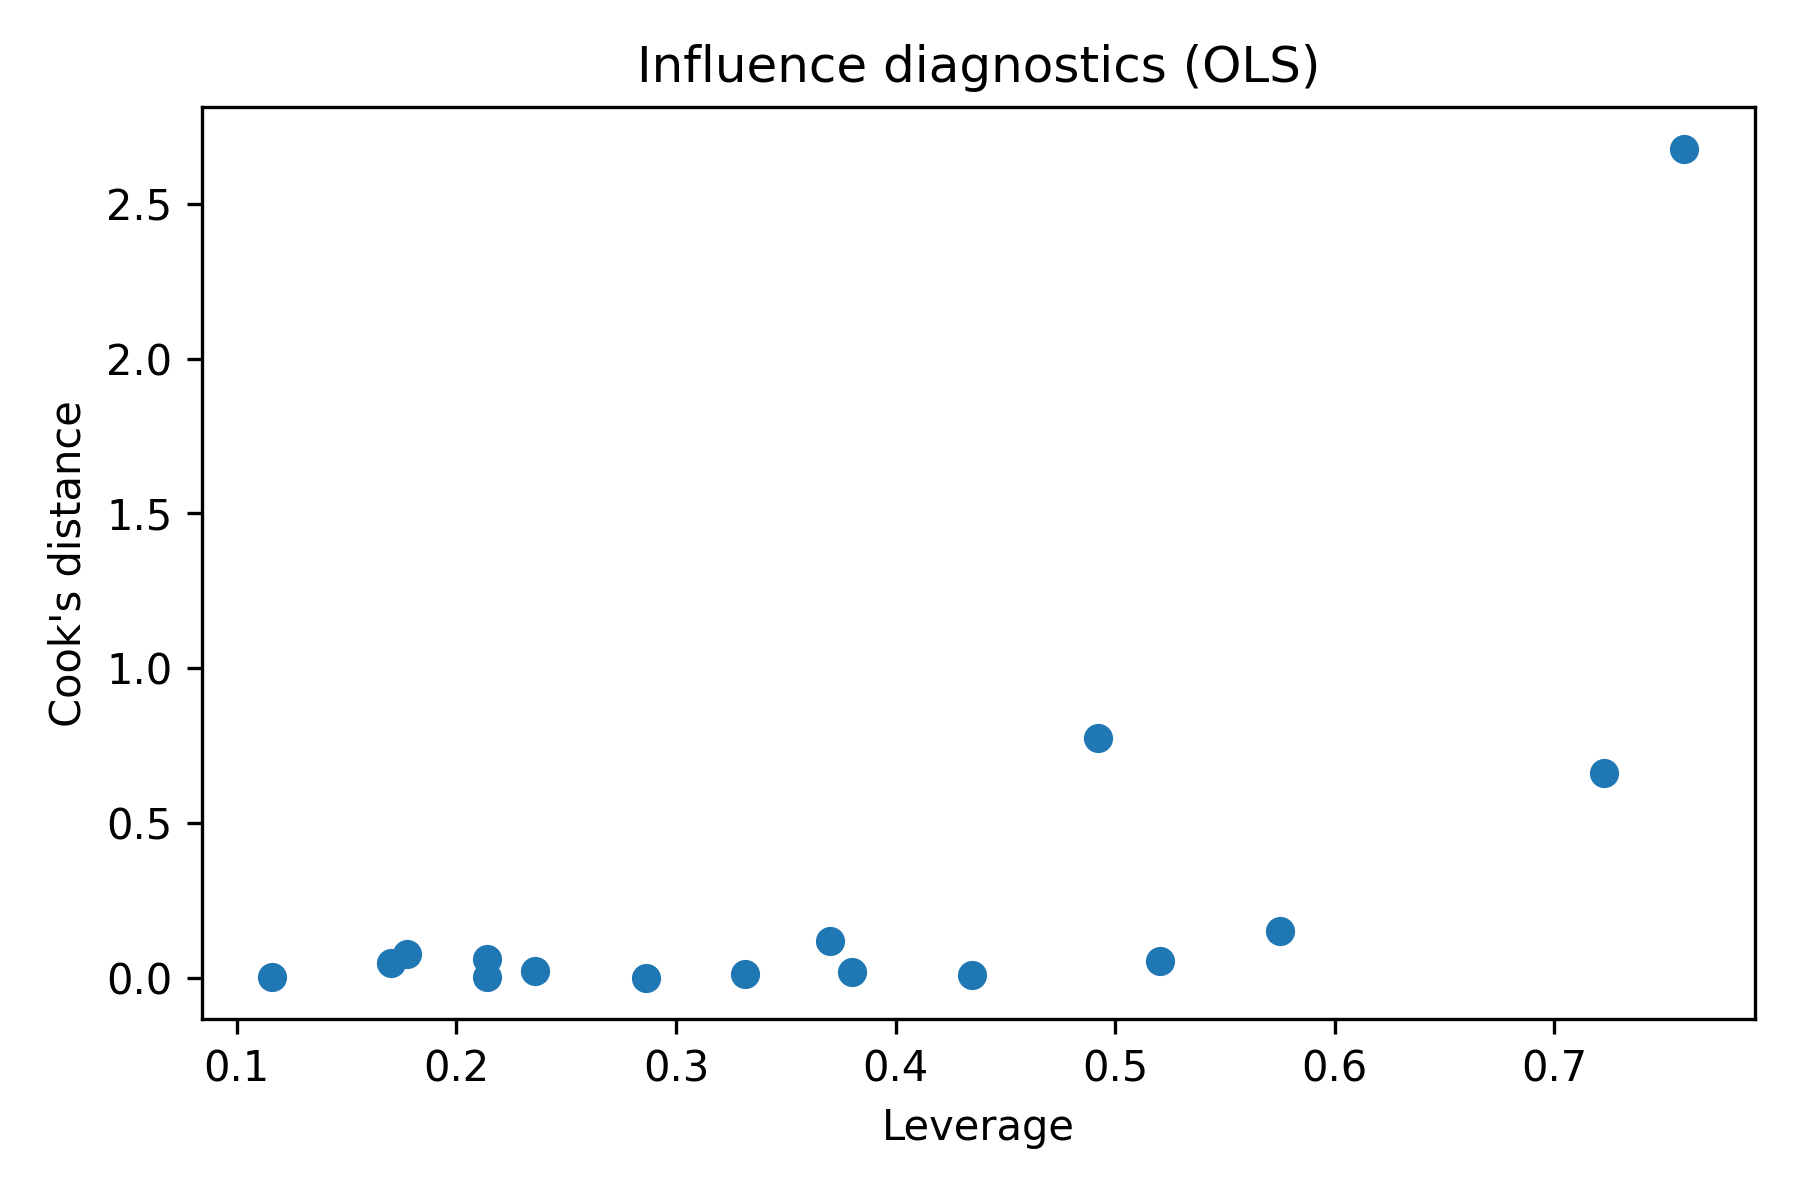

In [40]:
from IPython.display import Image
Image(filename=str(FIG_DIR / "ols_leverage_vs_cooks.png"))

# 9e. VIF table – multicollinearity diagnostics

In [41]:
X = df[covariates].copy()
X = sm.add_constant(X)

vif_tbl = pd.DataFrame({
    "variable": X.columns,
    "VIF": [variance_inflation_factor(X.values, i)
            for i in range(X.shape[1])]
})
print(vif_tbl)

                                     variable          VIF
0                                       const  5960.235469
1  Third_Vaccination_Rate_End_Pandemic_Year_3     4.805987
2             Excess_mortality_Pandemic_Year2     6.603040
3                               Mean_Age_2022     9.024024
4                         GDP_per_capita_2022     6.212713
5                   Risk_of_poverty_rate_2022     1.478605


# 9f. HC3 robust standard errors and Breusch–Pagan test

In [42]:
# HC3 robust SEs
ols_hc3 = ols_model.get_robustcov_results(cov_type="HC3")
print(ols_hc3.summary())

# Breusch–Pagan test
from statsmodels.stats.diagnostic import het_breuschpagan

lm, lm_p, fvalue, f_p = het_breuschpagan(ols_model.resid, X)
print(f"Breusch–Pagan: LM p={lm_p:.3g}, F p={f_p:.3g}")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     36.06
Date:                Sat, 06 Dec 2025   Prob (F-statistic):           4.39e-06
Time:                        16:09:43   Log-Likelihood:                -19.380
No. Observations:                  16   AIC:                             50.76
Df Residuals:                      10   BIC:                             55.40
Df Model:                           5                                         
Covariance Type:                  HC3                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

/home/codespace/.local/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=16 observations were given.
  return hypotest_fun_in(*args, **kwds)


# 9g. Full correlation grid with FDR / Bonferroni

In [43]:
all_predictors = predictors  # reuse
all_outcomes = outcomes

rows = []
for pred in all_predictors:
    for out in all_outcomes:
        r_ij, p_ij = stats.pearsonr(df[pred], df[out])
        rows.append({
            "predictor": pred,
            "outcome": out,
            "r": r_ij,
            "p_raw": p_ij,
        })

corr_grid = pd.DataFrame(rows)

pvals = corr_grid["p_raw"].values
for method, label in [
    ("fdr_bh", "p_fdr"),
    ("bonferroni", "p_bonf"),
]:
    _, p_adj, _, _ = multipletests(pvals, method=method)
    corr_grid[label] = p_adj

corr_grid["abs_r"] = corr_grid["r"].abs()
corr_grid["sig_fdr"] = corr_grid["p_fdr"] < 0.05
corr_grid["sig_bonf"] = corr_grid["p_bonf"] < 0.05

corr_grid.to_csv(RESULTS_DIR / "corr_grid_with_FDR_Bonferroni.csv", index=False)

delta_corr = (
    corr_grid[corr_grid["outcome"] == "Delta_EM_Year2_3"]
    .set_index("predictor")
    .sort_values("abs_r", ascending=False)
)
print("\n=== Correlations with ΔEM (Year2→Year3), sorted by |r| ===")
print(delta_corr[["r", "p_raw", "p_fdr", "p_bonf", "sig_fdr", "sig_bonf"]])



=== Correlations with ΔEM (Year2→Year3), sorted by |r| ===
                                                    r         p_raw     p_fdr  \
predictor                                                                       
Third_Vaccination_Rate_End_Pandemic_Year_3   0.931651  1.557630e-07  0.000006   
Second_Vaccination_Rate_End_Pandemic_Year_3  0.794929  2.332086e-04  0.002099   
Mean_Age_2022                               -0.487236  5.558923e-02  0.166768   
Care_Needs_Percent_31.12.2021               -0.393007  1.320993e-01  0.358464   
Risk_of_poverty_rate_2022                    0.386318  1.394027e-01  0.358464   
GDP_per_capita_2022                          0.327716  2.153079e-01  0.476150   
COVID_infections_Pandemic_Year3              0.247523  3.553437e-01  0.639619   
COVID_deaths_Pandemic_Year3                  0.150584  5.777565e-01  0.831969   
Measures_Overall_Pandemic_Year3             -0.006370  9.813215e-01  0.981321   

                                               p

### Corr grid with FDR Bonferroni
https://github.com/slashennui/german_signal/blob/main/notebooks/full_results/corr_grid_with_FDR_Bonferroni.csv

# 9h. East vs West comparison (ΔEM and regression with region indicator)

In [44]:
east_states = {
    "Brandenburg",
    "Mecklenburg-Vorpommern",
    "Sachsen",
    "Sachsen-Anhalt",
    "Thüringen",
}
df["is_east"] = df["Federal State"].isin(east_states).astype(int)
east_delta = delta23[df["is_east"] == 1]
west_delta = delta23[df["is_east"] == 0]
t_stat, p_t = stats.ttest_ind(east_delta, west_delta, equal_var=False)

print("\nEast vs West ΔEM (Year2→Year3):")
print(f" East mean = {east_delta.mean():.2f}")
print(f" West mean = {west_delta.mean():.2f}")
print(f" t = {t_stat:.3f}, p = {p_t:.3g}")

covariates_region = [
    "Third_Vaccination_Rate_End_Pandemic_Year_3",
    "Excess_mortality_Pandemic_Year2",
    "is_east",
]
X_reg = sm.add_constant(df[covariates_region])
y_reg = delta23
ols_region = sm.OLS(y_reg, X_reg).fit()
print("\nOLS with region indicator (ΔEM ~ booster + EM2 + is_east):")
print(ols_region.summary())


East vs West ΔEM (Year2→Year3):
 East mean = 1.28
 West mean = 6.54
 t = -5.381, p = 0.000314

OLS with region indicator (ΔEM ~ booster + EM2 + is_east):
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     36.68
Date:                Sat, 06 Dec 2025   Prob (F-statistic):           2.53e-06
Time:                        16:09:43   Log-Likelihood:                -22.101
No. Observations:                  16   AIC:                             52.20
Df Residuals:                      12   BIC:                             55.29
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                 coef  

/home/codespace/.local/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=16 observations were given.
  return hypotest_fun_in(*args, **kwds)


# 10. Markdown tables

In [45]:
def df_to_markdown(df_md: pd.DataFrame) -> str:
    return df_md.to_markdown(index=False)

# ---------- Tables A1 & A2 ----------

high_low_table = (
    group_means.rename_axis("group")
    .reset_index()
    .rename(columns={
        "Excess_mortality_Pandemic_Year1": "EM_Year1",
        "Excess_mortality_Pandemic_Year2": "EM_Year2",
        "Excess_mortality_Pandemic_Year3": "EM_Year3",
    })
)

core_corr_table = pd.DataFrame([{
    "predictor": "Booster rate Y3",
    "outcome": "ΔEM (Year2→Year3)",
    "r": round(r, 3),
    "R2": round(r2, 3),
    "CI_low": round(r_lo, 3),
    "CI_high": round(r_hi, 3),
    "N_states": n_states,
    "perm_p": round(p_perm, 5),
}])

# ---------- Table A3 base: full ΔEM row from corr grid ----------

# keep predictor as a column
delta_corr_table = delta_corr.reset_index()

# nicer predictor labels for display
pretty_names = {
    "Third_Vaccination_Rate_End_Pandemic_Year_3": "Booster rate Y3",
    "Second_Vaccination_Rate_End_Pandemic_Year_3": "2-dose rate Y3",
    "COVID_deaths_Pandemic_Year3": "COVID deaths Y3",
    "COVID_infections_Pandemic_Year3": "COVID infections Y3",
    "GDP_per_capita_2022": "GDP per capita",
    "Mean_Age_2022": "Mean age",
    "Risk_of_poverty_rate_2022": "Poverty rate",
    "Care_Needs_Percent_31.12.2021": "Care needs %",
    "Measures_Overall_Pandemic_Year3": "Policy stringency Y3",
}
delta_corr_table["predictor"] = delta_corr_table["predictor"].replace(pretty_names)

# only the columns we want to show, with nicer formatting
delta_corr_view = delta_corr_table[
    ["predictor", "r", "p_raw", "p_fdr", "p_bonf", "sig_fdr", "sig_bonf"]
].copy()

# round numeric columns
for col in ["r", "p_raw", "p_fdr", "p_bonf"]:
    delta_corr_view[col] = delta_corr_view[col].map(lambda x: f"{x:.3f}")

# use checkmarks instead of True/False
delta_corr_view["sig_fdr"] = delta_corr_view["sig_fdr"].map({True: "✓", False: ""})
delta_corr_view["sig_bonf"] = delta_corr_view["sig_bonf"].map({True: "✓", False: ""})

# ---------- PNG versions of the key tables (needs table_to_png() defined above) ----------

table_to_png(
    high_low_table,
    "table_A1_high_vs_low_booster.png",
    title="Table A1 – High vs low booster states: excess mortality by year",
)

table_to_png(
    core_corr_table,
    "table_A2_core_corr_booster_deltaEM.png",
    title="Table A2 – Core correlation: booster vs ΔEM (Year2→Year3)",
)

table_to_png(
    delta_corr_view,
    "table_A3_predictors_vs_deltaEM.png",
    title="Table A3 – Predictors vs ΔEM (Year2→Year3) with FDR / Bonferroni",
)

# ---------- Markdown file with the same tables ----------

md_lines = []
md_lines.append("# Key tables\n")

md_lines.append("## High vs low booster states – excess mortality by year\n")
md_lines.append(df_to_markdown(high_low_table))
md_lines.append("\n\n")

md_lines.append("## Core booster vs ΔEM correlation\n")
md_lines.append(df_to_markdown(core_corr_table))
md_lines.append("\n\n")

md_lines.append("## Predictors vs ΔEM (Year2→Year3) with FDR / Bonferroni\n")
md_lines.append(df_to_markdown(delta_corr_view))
md_lines.append("\n")

(RESULTS_DIR / "tables.md").write_text("\n".join(md_lines), encoding="utf-8")

print("\nAll figures written to:", FIG_DIR.resolve())
print("Results tables written to:", RESULTS_DIR.resolve())


Saved table PNG -> figures/table_A1_high_vs_low_booster.png
Saved table PNG -> figures/table_A2_core_corr_booster_deltaEM.png
Saved table PNG -> figures/table_A3_predictors_vs_deltaEM.png

All figures written to: /workspaces/codespaces-jupyter/notebooks/figures
Results tables written to: /workspaces/codespaces-jupyter/notebooks/full_results


---

## Full set of figures and key results

---

### Figure 1. Booster uptake vs change in excess mortality (Year 2 → Year 3) (GitHub rendered)

![](https://raw.githubusercontent.com/slashennui/german_signal/main/notebooks/figures/core_corr_booster_delta23.png)

This scatter plot shows the relationship between booster vaccination rate by the
end of 2022 and the **change in excess mortality from Year 2 to Year 3** for the
16 German federal states. Each point is a state, labelled by its abbreviation.
The fitted regression line and confidence interval highlight a very strong
positive correlation (r ≈ 0.93, R² ≈ 0.87).

---

### Figure 2. High‑ vs low‑booster states: 3‑year excess‑mortality trajectories (GitHub rendered)

![](https://raw.githubusercontent.com/slashennui/german_signal/main/notebooks/figures/trend_reversal_high_low.png)

States are split at the median booster uptake into “high‑booster” and
“low‑booster” groups. The lines show average excess mortality in Year 1–3 for
each group. High‑booster states started with **much lower** excess mortality,
but by Year 3 they show **higher** excess mortality than low‑booster states.

---

### Figure 3. COVID‑labelled deaths vs all‑cause excess mortality by year (GitHub rendered)

![](https://raw.githubusercontent.com/slashennui/german_signal/main/notebooks/figures/covid_deaths_vs_em_by_year.png)

Three panels show, for each year, the correlation between COVID‑labelled deaths
and all‑cause excess mortality across states. The link is moderate in Year 1,
weaker in Year 2, and even weaker in Year 3, illustrating the **decoupling** of
COVID labels from overall mortality.

---

### Figure 4. Booster uptake vs COVID burden and case‑fatality changes (GitHub rendered)

![](https://raw.githubusercontent.com/slashennui/german_signal/main/notebooks/figures/booster_vs_covid_metrics.png)

Three panels show booster uptake vs:

1. COVID‑labelled deaths in Year 3  
2. Change in crude case‑fatality ratio (Year 2 → Year 3)  
3. COVID infections in Year 3  

None of these relationships look strongly protective. This undercuts the idea
that higher booster uptake is just a proxy for “more COVID” in those states.

---

### Figure 5. Predictor–outcome correlation heatmap (GitHub rendered)

![](https://raw.githubusercontent.com/slashennui/german_signal/main/notebooks/figures/predictor_outcome_heatmap.png)

This correlation matrix compares several predictors (booster and 2‑dose
coverage, COVID metrics, demographics, socio‑economics, care needs, policy
stringency) against four mortality outcomes (excess mortality in Years 1–3 and
the Year‑2→3 change). Visually, booster and 2‑dose coverage stand out as the
only strong predictors of the Year‑2→3 mortality change.

---

### Figure 6. Jackknife robustness: leave‑one‑state‑out correlations (GitHub rendered)

![](https://raw.githubusercontent.com/slashennui/german_signal/main/notebooks/figures/jackknife_correlations.png)

Each bar shows the correlation between booster uptake and Δ excess mortality
when one state is left out. The correlation stays very high (≈ 0.92–0.95) no
matter which state is removed, so the pattern is **not driven by a single
outlier**.

---

### Figure 7. Permutation test: how extreme is the observed correlation? (GitHub rendered)

![](https://raw.githubusercontent.com/slashennui/german_signal/main/notebooks/figures/permutation_histogram.png)

The histogram shows the distribution of correlation coefficients obtained when
booster rates are randomly shuffled across states (5,000 permutations). The
vertical line is the observed r ≈ 0.93. Almost no shuffled dataset reaches this
value; the two‑sided permutation p‑value is ≈ 0.0002.

---

### Figure 8. Bootstrap distribution of the correlation (GitHub rendered)

![](https://raw.githubusercontent.com/slashennui/german_signal/main/notebooks/figures/bootstrap_r_booster_delta23.png)

This shows the bootstrap distribution of the Pearson correlation (10,000
resamples) between booster uptake and Δ excess mortality. The 95% bootstrap
interval is roughly [0.84, 0.97], confirming that the strong positive
association is not an artefact of one particular sample.

---

### Figure 9. Regression diagnostics (OLS on Δ excess mortality) (GitHub rendered)

![](https://raw.githubusercontent.com/slashennui/german_signal/main/notebooks/figures/ols_resid_vs_fitted.png)

![](https://raw.githubusercontent.com/slashennui/german_signal/main/notebooks/figures/ols_qq.png)

![](https://raw.githubusercontent.com/slashennui/german_signal/main/notebooks/figures/ols_leverage_vs_cooks.png)

These plots check the ordinary least squares model of Δ excess mortality on
booster uptake, prior Year‑2 excess mortality and basic covariates
(age, GDP, poverty rate):

- Residuals vs fitted: no obvious non‑linear pattern or heteroskedasticity  
- Q‑Q plot: residuals reasonably close to normal for N = 16  
- Leverage vs Cook’s distance: no single state unduly dominates the fit  

They support using a simple linear model as a **descriptive** summary of the
state‑level pattern.

---

### Tables A1–A3. Key numerical results  (GitHub rendered)

For readers who prefer numbers over pictures, the full tables are available in
the GitHub repo https://github.com/slashennui/german_signal/blob/main/notebooks/full_results/tables.md

The most important pieces are:

- **Table A1 – High vs low booster states, EM by year**  
  (Year‑1–3 excess mortality means for the two groups.)

![](https://raw.githubusercontent.com/slashennui/german_signal/main/notebooks/figures/table_A1_high_vs_low_booster.png) 

- **Table A2 – Core correlation summary** 
  Booster vs Δ excess mortality: r ≈ 0.93, R² ≈ 0.87,
  95% CI ≈ [0.81, 0.98], permutation p ≈ 0.00020.

![](https://raw.githubusercontent.com/slashennui/german_signal/main/notebooks/figures/table_A2_core_corr_booster_deltaEM.png)

- **Table A3 – Predictors vs ΔEM with FDR / Bonferroni**  
  Among all predictors examined, only booster and 2‑dose coverage remain
  significant after multiple‑testing correction.

![](https://raw.githubusercontent.com/slashennui/german_signal/main/notebooks/figures/table_A3_predictors_vs_deltaEM.png)

---

### Corr grid with FDR Bonferroni 
https://github.com/slashennui/german_signal/blob/main/notebooks/full_results/corr_grid_with_FDR_Bonferroni.csv

---


All figures above are generated directly from the public Kuhbandner & Reitzner
RSOS 2025 dataset

Data archive (OSF): https://osf.io/xg8eu/

Paper (Royal Society Open Science): https://royalsocietypublishing.org/doi/10.1098/rsos.250790

---

# Environment / versions

In [46]:
import sys, platform
import numpy, pandas, matplotlib, statsmodels, scipy

print("Python", sys.version)
print("Platform:", platform.platform())
print("numpy", numpy.__version__)
print("pandas", pandas.__version__)
print("matplotlib", matplotlib.__version__)
print("statsmodels", statsmodels.__version__)
print("scipy", scipy.__version__)

Python 3.12.1 (main, May  6 2025, 20:30:25) [GCC 9.4.0]
Platform: Linux-6.8.0-1030-azure-x86_64-with-glibc2.31
numpy 2.2.5
pandas 2.2.2
matplotlib 3.8.4
statsmodels 0.14.5
scipy 1.15.2


questions? contact manu ->  x34mev@proton.me